## Very Short Term Price Forecasting - New England Dataset
- Very Short Term == next hour price
- Main objective is to optimize method for forecasting very short term prices i.e. Next hour Prices
- Error Metrics are Mean Absolute Error and Mean Absolute Percentage Error
- Use RVM and Stack it with other Models to improve Generalization Error

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from scipy import stats

#import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
#specify columns to load
cols_use_price = ['Date', 'Hour', 'DA_DEMD', 'DryBulb', 'DewPnt', 'DA_LMP', 'Day', 'DA_EC', 'DA_CC', 'DA_MLC']

### Load Data

In [5]:
#2012-14 dataset
#dataset of 2014 is used only to set the 1st hour of January, 2014 (00:00) as target value
data1 = pd.read_csv('loadData1.csv', usecols=cols_use_price, skiprows=range(1415,1439))
data2 = pd.read_csv('loadData2.csv', usecols=cols_use_price)
data3 = pd.read_csv('loadData3.csv', usecols=cols_use_price)

### Feature Engineering

In [6]:
#functions for converting string to datetime objects
def convert_string_to_datetime(string):
    datetime_obj = datetime.strptime(string, "%d-%b-%y")
    return datetime_obj.date()

#format is different for 2012,2013,2014
def convert_string_to_datetime2(string):
    datetime_obj = datetime.strptime(string, "%m/%d/%Y")
    return datetime_obj.date()

#format for natural Gas prices
def convert_string_to_datetime4(string):
    datetime_obj = datetime.strptime(string, "%Y-%m-%d")
    return datetime_obj.date()

In [7]:
#append year wise data together to one single file
tot_data = data1.append([data2], ignore_index=True)

In [8]:
tot_data['Date'] = tot_data['Date'].apply(convert_string_to_datetime2)
tot_data['Date'] = pd.to_datetime(tot_data['Date'])

In [9]:
#function to get day from date
def get_day_from_date(date_time_obj):
    return int(date_time_obj.date().day)

#function to get month from date
def get_month_from_date(date_time_obj):
    return int(date_time_obj.date().month)

In [10]:
tot_data['Day_Date'] = tot_data['Date'].apply(get_day_from_date)

In [11]:
tot_data.head()

,Date,Hour,DA_DEMD,DA_LMP,DA_EC,DA_CC,DA_MLC,DryBulb,DewPnt,Day,Day_Date
0,2012-01-01,1,10711.0,35.12,35.22,0.0,-0.10,35,33,1,1
1,2012-01-01,2,10276.0,33.38,33.39,0.0,-0.01,35,33,1,1
2,2012-01-01,3,9868.0,30.26,30.30,0.0,-0.04,36,33,1,1
3,2012-01-01,4,9771.0,28.88,28.88,0.0,0.00,36,33,1,1
4,2012-01-01,5,9884.0,20.23,20.21,0.0,0.02,36,33,1,1


#### Add Target Labels - Next Hour Data

In [12]:
tot_data_labels = list(tot_data['DA_LMP'][1:])
tot_data_labels.append(data3['DA_LMP'][0])

In [13]:
tot_data = tot_data.reset_index(drop=True)
print("Done")

Done


In [14]:
tot_data['TARGET_DA_LMP'] = tot_data_labels

#### Add previous day same hour price
This should be more useful for very short term than prev week

In [15]:
prev_day_da_lmp_targ = tot_data['DA_LMP'][1:-24]
prev_day_da_lmp_targ = prev_day_da_lmp_targ.reset_index(drop=True)

prev_day_da_demd_targ = tot_data['DA_DEMD'][1:-24]
prev_day_da_demd_targ = prev_day_da_demd_targ.reset_index(drop=True)

prev_day_dry_bulb_targ = tot_data['DryBulb'][1:-24]
prev_day_dry_bulb_targ = prev_day_dry_bulb_targ.reset_index(drop=True)

temp_df = pd.DataFrame({
    'prev_day_da_lmp': prev_day_da_lmp_targ,
    'prev_day_da_demd': prev_day_da_demd_targ,
    'prev_day_dry_bulb': prev_day_dry_bulb_targ,
    'actual_da_lmp': tot_data['DA_LMP'][0:-25],
    'actual_da_demd': tot_data['DA_DEMD'][0:-25],
    'actual_dry_bulb': tot_data['DryBulb'][0:-25]
})

temp_df['chg_in_da_demd'] = temp_df['actual_da_demd'] - temp_df['prev_day_da_demd']
temp_df['chg_in_dry_bulb'] = temp_df['actual_dry_bulb'] - temp_df['prev_day_dry_bulb']
temp_df['chg_in_da_lmp'] = temp_df['actual_da_lmp'] - temp_df['prev_day_da_lmp']

In [16]:
tot_data = tot_data[24:-1]
tot_data = tot_data.reset_index(drop=True)

In [17]:
tot_data = pd.merge(tot_data, temp_df[['prev_day_da_demd','prev_day_da_lmp', 'prev_day_dry_bulb',
                           'chg_in_da_demd', 'chg_in_da_lmp', 'chg_in_dry_bulb']], how='inner', 
                    left_index=True, right_index=True)
len(tot_data)

17495

#### Add daily means to the data

In [18]:
mean_values = tot_data.groupby('Date', as_index=False).mean()[['Date','DA_DEMD', 'DA_LMP', 'DryBulb', 'DewPnt']]
temp = pd.merge(tot_data, mean_values, how='inner', left_on='Date', right_on='Date', 
                suffixes=('_actual_value','_daily_mean'))
tot_data = temp

#### Add crude oil prices

In [19]:
crude_oil = pd.read_csv('CurdeOil.csv', delimiter='\t')
crude_oil = crude_oil[::-1]
crude_oil = crude_oil.reset_index(drop=True)
crude_oil = crude_oil[2:]
crude_oil = crude_oil.reset_index(drop=True)

def get_num_from_vol_str(string):
    match = re.search(r"(\d+)", string)
    if match!=None:
        return float(match.group(1))
    
crude_oil = crude_oil[['Date', 'Price', 'Vol.']]
crude_oil['Date'] = crude_oil['Date'].apply(convert_string_to_datetime)
crude_oil['Date'] = pd.to_datetime(crude_oil['Date'])

crude_oil['Crude_Oil_Price'] = crude_oil['Price']
crude_oil['Crude_Oil_Vol'] = crude_oil['Vol.']

crude_oil = crude_oil.drop('Price', axis=1)
crude_oil = crude_oil.drop('Vol.', axis=1)

temp = pd.merge(tot_data, crude_oil, how='outer', left_on='Date', right_on='Date', suffixes=('_X','_crude_oil'))
temp.reset_index(drop=True)
temp['Crude_Oil_Price'] = temp['Crude_Oil_Price'].fillna(method='bfill')
temp['Crude_Oil_Vol'] = temp['Crude_Oil_Vol'].fillna(method='bfill')
temp = temp[0:len(tot_data)]
tot_data = temp

tot_data['Crude_Oil_Vol'] = tot_data['Crude_Oil_Vol'].apply(get_num_from_vol_str)


#### Add Natural Gas Price

In [20]:
natural_gas = pd.read_csv('natural_gas.csv')

In [21]:
natural_gas.tail()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
750,2012-01-09,3.011,3.032,2.977,3.011,NaN,3.011,115212.0,165717.0
751,2012-01-06,2.960,3.077,2.955,3.062,NaN,3.062,132139.0,172208.0
752,2012-01-05,3.122,3.123,2.947,2.980,NaN,2.980,171870.0,171072.0
753,2012-01-04,2.978,3.123,2.975,3.096,NaN,3.096,137309.0,173289.0
754,2012-01-03,2.969,3.074,2.936,2.993,NaN,2.993,110030.0,180477.0


In [22]:
natural_gas['Date'] = natural_gas['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [23]:
natural_gas.rename(columns={
    'Open': 'Natural_Gas_Price_Open',
    'Last': 'Natural_Gas_Price_Close'
}, inplace=True)

In [24]:
natural_gas['Date'] = pd.to_datetime(natural_gas['Date'])

In [25]:
tot_data = pd.merge(left=tot_data, right=natural_gas[['Date', 'Natural_Gas_Price_Open', 'Natural_Gas_Price_Close']],
        how='left', on='Date')

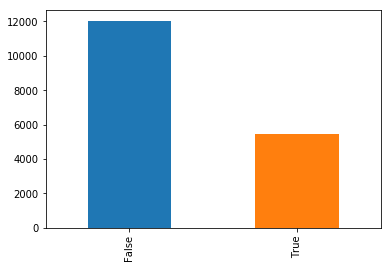

In [26]:
tot_data['Natural_Gas_Price_Open'].isnull().value_counts().plot(kind='bar')

### Note: Natural gas data contains high amount of missing values, not used as a feature

### ------------ Data Prep Ends Here ---------------

### Split Data to Train and Test set

In [27]:
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler

C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
X = tot_data

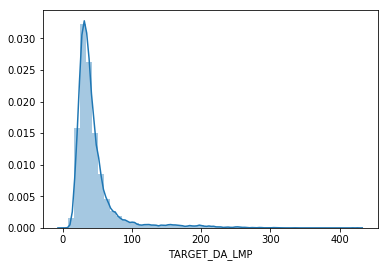

In [29]:
sns.distplot(X['TARGET_DA_LMP'])

In [30]:
for i in range(len(X['TARGET_DA_LMP'])):
    if(X['TARGET_DA_LMP'][i] < 1):
        X['TARGET_DA_LMP'][i] = (X['TARGET_DA_LMP'][i-1]+X['TARGET_DA_LMP'][i+1])/2

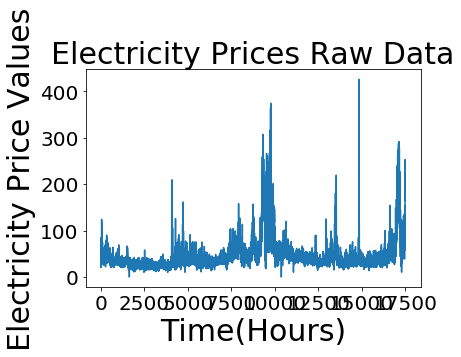

In [31]:
plt.plot(X['DA_LMP_actual_value'])
plt.xlabel("Time(Hours)", {'fontsize':30})
plt.ylabel("Electricity Price Values",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Electricity Prices Raw Data", {'fontsize':30})
plt.savefig("plot_electricity_prices.jpg", format='jpg', bbox_inches='tight', dpi=600)

- Split Method - **23 Days** as **Training Set** for each month and remaining as **Test Set**

In [32]:
#train1 = X.query('Day_Date <24 & Date < datetime(2013,1,1)')#[(X.Day_Date <24) and (X.Date > )]
#train2 = X.query('Day_Date <24 & Date > datetime(2013,2,1)')#X[X['Date'] >= datetime(2013,1,1)]
#test1 = X.query('Day_Date >24 & Date < datetime(2013,1,1)')
#test2 = X.query('Day_Date >24 & Date > datetime(2013,2,1) & Date < datetime(2013,12,1)')
#[X.Day_Date>=24 and X.Date >= datetime(2013,1,1)]

train = X[X.Day_Date<24]
test = X[X.Day_Date>=24]

#train1 = train.query('Day_Date < 2')
#train2 = train.query('Day_Date > 9 & Day_Date < 12')
#train3 = train.query('Day_Date > 18 & Day_Date < 22')
#train = train1.append(train2)
#train = train.append(train3)
#test = test1.append(test2)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(len(train))
print(len(test))

13224
4271


### Selecting Specific Columns and Feature Scaling

In [33]:
#conditions = [x for x in train.columns if 'Date' 
#              not in x and 'TARGET_DA_LMP' not in x]
#test_conditions = [x for x in train.columns if 'Date' 
#             not in x and 'TARGET_DA_LMP' not in x and 'DewPnt_daily_mean' not in x 
#             and 'DryBulb_daily_mean' not in x and 'Prev_Week_DA_DEMD' not in x 
#                and 'DA_DEMD_daily_mean' not in x and 'DA_LMP_daily_mean' not in x 
#               ]

cond_to_use = ['DA_LMP_actual_value', 'chg_in_da_demd', 'chg_in_da_lmp', 'prev_day_da_lmp', 'DA_LMP_daily_mean',
              'Hour', 'DA_DEMD_actual_value', 'DryBulb_actual_value', 'DryBulb_daily_mean', 
               'Crude_Oil_Price']

train_x = train[cond_to_use]
train_y = pd.DataFrame(train['TARGET_DA_LMP'])
test_x = test[cond_to_use]
test_y = pd.DataFrame(test['TARGET_DA_LMP'])

In [34]:
std_scaler = StandardScaler()
train_x_scaled = std_scaler.fit_transform(train_x)
test_x_scaled = std_scaler.fit_transform(test_x)
train_y_scaled = std_scaler.fit_transform(train_y)

### MAPE Function and Other Error Metrics

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#function to calculate mape
def mean_absolute_percentage_error(y_pred, y_true): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def point_absolute_percentage_error(y_pred, y_true):
    return np.abs((y_true - y_pred) / y_true) * 100

#GIVE Everything you can imagine of function - SD, VAR, MIN and MAX ERROR, CI
def get_CI_VAR_SD(error_list):
    t = stats.t.ppf(1-0.025, len(error_list)-1)
    max_err = np.mean(error_list) + (t * (np.std(error_list)/np.sqrt(len(error_list))))
    min_err = np.mean(error_list) - (t * (np.std(error_list)/np.sqrt(len(error_list))))
    ci = ((max_err - np.mean(error_list))/np.mean(error_list))*100
    sd = np.std(error_list)
    var = np.var(error_list)
    return (max_err, min_err, ci, sd, var)

## Make custom scoring function

In [36]:
from sklearn.metrics.scorer import make_scorer

In [37]:
def inverse_scaled_mae_scoring(true_y_scaled, pred_y_scaled):
    true = std_scaler.inverse_transform(true_y_scaled)
    pred = std_scaler.inverse_transform(pred_y_scaled)
    return mean_absolute_error(true, pred)
    
inversed_mae_score = make_scorer(inverse_scaled_mae_scoring, greater_is_better=False)

### PRICE PREDICTIONS

In [38]:
#import all models required from scikit learn

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from skbayes.rvm_ard_models import RVR


from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score

C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'xgboost'

In [39]:
import timeit

### Function to save model to disk

In [123]:
import pickle

def save_model(model_obj, filename):
    try:
        with open(filename, 'wb') as fid:
            pickle.dump(model_obj, fid) 
        print("Done")
    except Exception as e: print(e)

In [129]:
def load_saved_pickle_model(fileanme):
    return pickle.load(open(filename, 'rb'))

### Random Forest

In [604]:
params = {
    'max_depth': [13, 10, 7], #np.linspace(50,100,5, dtype=int),
    'n_estimators': [1000, 700], #np.linspace(500,2000,5, dtype=int)
    'bootstrap': [True]
}

#rf_reg_price = GridSearchCV(RandomForestRegressor(), params, n_jobs=-1, cv=7, scoring='neg_mean_squared_error')
rf_reg_price = RandomForestRegressor(max_depth=8, n_estimators=700, bootstrap=True)

start = timeit.default_timer()

rf_reg_price = rf_reg_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)


try:
    print(rf_reg_price.best_params_)
    print("\n")
    print(rf_reg_price.best_score_)
except:
    print("Did Not Use GridSearch")

Time:  32.2401946799946
Did Not Use GridSearch


#### Training Error and Test Error- MAPE

In [605]:
#train mape
rf_preds_price_train = rf_reg_price.predict(train_x_scaled)
rf_preds_price_train = std_scaler.inverse_transform(rf_preds_price_train)
err = mean_absolute_percentage_error(rf_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rf_preds_price = rf_reg_price.predict(test_x_scaled)
rf_preds_price = std_scaler.inverse_transform(rf_preds_price)
err = mean_absolute_percentage_error(rf_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_rf = point_absolute_percentage_error(rf_preds_price, test_y['TARGET_DA_LMP'])
max_err_rf, min_err_rf, ci_rf, sd_rf, var_rf = get_CI_VAR_SD(point_err_rf)
print(max_err_rf, min_err_rf, ci_rf, sd_rf, var_rf)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list_rf =[]
mae_list_rf =[]
rmse_list_rf =[]
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(days_list[i], np.sum(days_list[:i+2])*24)
    temp_list_rf.append(mean_absolute_percentage_error(
        rf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list_rf.append(mean_absolute_error(
        rf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list_rf.append(np.sqrt(mean_squared_error(
        rf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list_rf

Train:  5.5091489321789355
Test:  6.4313006631964695
6.62535400286 6.23724732353 3.01732650716 6.468665515778455 41.84363355502135


[4.874103621574653,
 5.788760050612247,
 7.007408984425813,
 7.489938804737875,
 6.2696373035851085,
 7.29452881740804,
 5.567391329562616,
 6.352847808745839,
 5.21713788916108,
 5.3772782890635975,
 7.065472303507754,
 8.063502307507147,
 10.154023726156629,
 7.102607082219378,
 7.026400741773401,
 5.562165822442115,
 5.341472205205112,
 5.878533473319444,
 4.411912968920499,
 5.503075821289197,
 5.206422927038839,
 4.782786291152919,
 7.73332601012288,
 9.305880376709538]

In [606]:
rf_preds_price

array([  25.5053257 ,   25.59805983,   24.1824263 , ...,  173.7128372 ,
        161.804741  ,  152.09832182])

# Level 1 Learning

### eXtreme Gradient Boosting XGBoost

#### Sensitivity Analysis

MaxDepth

In [697]:
choices = [2,7,11,15,25]
cv_scores = []

for i in choices:
    sensitivity_analysis = XGBRegressor(silent=False, max_depth=i, n_estimators=100)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    cv_scores.append(np.mean(cross_val_scores) * -1)

pd.DataFrame({
    'Value': choices,
    '3 Fold CV MAE Score': cv_scores
})

,3 Fold CV MAE Score,Value
0,3.573252,2
1,3.524680,7
2,3.908748,11
3,4.030522,15
4,4.052283,25


N-Estimators

In [699]:
choices = [400,600,800,1000]
cv_scores = []

for i in choices:
    sensitivity_analysis = XGBRegressor(silent=False, n_estimators=i)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    cv_scores.append(np.mean(cross_val_scores) * -1)

pd.DataFrame({
    'Value': choices,
    '3 Fold CV MAE Score': cv_scores
})

,3 Fold CV MAE Score,Value
0,3.351827,400
1,3.401441,600
2,3.398661,800
3,3.410650,1000


In [702]:
choices = [1,4,8,12,15,20]
cv_scores = []

for i in choices:
    sensitivity_analysis = XGBRegressor(silent=False, min_child_weight=i)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    cv_scores.append(np.mean(cross_val_scores) * -1)

pd.DataFrame({
    'Value': choices,
    '3 Fold CV MAE Score': cv_scores
})

,3 Fold CV MAE Score,Value
0,3.375454,1
1,3.342196,4
2,3.374500,8
3,3.353056,12
4,3.361940,15
5,3.330881,20


In [705]:
choices = [0.0005, 0.005, 0.01, 0.5, 1, 3]
cv_scores = []

for i in choices:
    sensitivity_analysis = XGBRegressor(silent=False, gamma=i)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    cv_scores.append(np.mean(cross_val_scores) * -1)

pd.DataFrame({
    'Value': choices,
    '3 Fold CV MAE Score': cv_scores
})

,3 Fold CV MAE Score,Value
0,3.375454,0.0005
1,3.375111,0.0050
2,3.375227,0.0100
3,3.447177,0.5000
4,3.508663,1.0000
5,3.709254,3.0000


Load Saved Pickle File

In [132]:
filename = 'model_xgb.pkl'
xgb_reg_preds_price = load_saved_pickle_model(filename)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [165]:
#train mape
xgb_reg_preds_price_train = xgb_reg_price.predict(train_x_scaled)
xgb_reg_preds_price_train = std_scaler.inverse_transform(xgb_reg_preds_price_train)
err = mean_absolute_percentage_error(xgb_reg_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
xgb_reg_preds_price = xgb_reg_price.predict(test_x_scaled)
xgb_reg_preds_price = std_scaler.inverse_transform(xgb_reg_preds_price)
err = mean_absolute_percentage_error(xgb_reg_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_xgb = point_absolute_percentage_error(xgb_reg_preds_price, test_y['TARGET_DA_LMP'])
max_err_xgb, min_err_xgb, ci_xgb, sd_xgb, var_xgb = get_CI_VAR_SD(point_err_xgb)
print(max_err_xgb, min_err_xgb, ci_xgb, sd_xgb, var_xgb)

Train:  4.863842159837237
Test:  6.02499238693311
6.20926023165 5.84072454221 3.05839132875 6.142471213628366 37.729952610253136


In [166]:
days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list1 =[]
mae_list1 = []
rmse_list1 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list1.append(mean_absolute_percentage_error(
        xgb_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list1.append(mean_absolute_error(
        xgb_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list1.append(np.sqrt(mean_squared_error(
        xgb_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
np.mean(temp_list1)

6.022648315679743

### RVM - RBF Kernel

#### Sensitivity 

n_iter

In [680]:
rbf_n_iter_range = [100, 400, 550, 600, 650, 800]
rbf_n_iter_sensitivity = []

for i in rbf_n_iter_range:
    sensitivity_analysis = RVR(kernel='rbf', gamma=0.001, verbose=10, n_iter=i)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    rbf_n_iter_sensitivity.append(np.mean(cross_val_scores) * -1)

Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 10
Iteration: 10, number of features in the model: 11
Iteration: 11, number of features in the model: 12
Iteration: 12, number of features in the model: 13
Iteration: 13, number of features in the model: 14
Iteration: 14, number of features in the model: 15
Iteration: 15, number of features in the model: 16
Iteration: 16, number of features in the model: 17
Iteration: 17, number of features in the model: 18
Iteration: 18, number of features in the model: 19
Iteration: 19, number of features in the model: 2

Iteration: 65, number of features in the model: 50
Iteration: 66, number of features in the model: 51
Iteration: 67, number of features in the model: 51
Iteration: 68, number of features in the model: 52
Iteration: 69, number of features in the model: 53
Iteration: 70, number of features in the model: 54
Iteration: 71, number of features in the model: 55
Iteration: 72, number of features in the model: 56
Iteration: 73, number of features in the model: 57
Iteration: 74, number of features in the model: 58
Iteration: 75, number of features in the model: 59
Iteration: 76, number of features in the model: 59
Iteration: 77, number of features in the model: 59
Iteration: 78, number of features in the model: 60
Iteration: 79, number of features in the model: 61
Iteration: 80, number of features in the model: 61
Iteration: 81, number of features in the model: 61
Iteration: 82, number of features in the model: 61
Iteration: 83, number of features in the model: 62
Iteration: 84, number of featur

Iteration: 37, number of features in the model: 33
Iteration: 38, number of features in the model: 34
Iteration: 39, number of features in the model: 35
Iteration: 40, number of features in the model: 36
Iteration: 41, number of features in the model: 37
Iteration: 42, number of features in the model: 38
Iteration: 43, number of features in the model: 39
Iteration: 44, number of features in the model: 40
Iteration: 45, number of features in the model: 40
Iteration: 46, number of features in the model: 41
Iteration: 47, number of features in the model: 41
Iteration: 48, number of features in the model: 42
Iteration: 49, number of features in the model: 42
Iteration: 50, number of features in the model: 43
Iteration: 51, number of features in the model: 43
Iteration: 52, number of features in the model: 44
Iteration: 53, number of features in the model: 44
Iteration: 54, number of features in the model: 45
Iteration: 55, number of features in the model: 46
Iteration: 56, number of featur

Iteration: 199, number of features in the model: 67
Iteration: 200, number of features in the model: 67
Iteration: 201, number of features in the model: 66
Iteration: 202, number of features in the model: 66
Iteration: 203, number of features in the model: 66
Iteration: 204, number of features in the model: 65
Iteration: 205, number of features in the model: 66
Iteration: 206, number of features in the model: 66
Iteration: 207, number of features in the model: 65
Iteration: 208, number of features in the model: 65
Iteration: 209, number of features in the model: 64
Iteration: 210, number of features in the model: 65
Iteration: 211, number of features in the model: 66
Iteration: 212, number of features in the model: 65
Iteration: 213, number of features in the model: 65
Iteration: 214, number of features in the model: 65
Algorithm converged !
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4

Iteration: 148, number of features in the model: 79
Iteration: 149, number of features in the model: 80
Iteration: 150, number of features in the model: 79
Iteration: 151, number of features in the model: 79
Iteration: 152, number of features in the model: 80
Iteration: 153, number of features in the model: 80
Iteration: 154, number of features in the model: 79
Iteration: 155, number of features in the model: 79
Iteration: 156, number of features in the model: 79
Iteration: 157, number of features in the model: 78
Iteration: 158, number of features in the model: 77
Iteration: 159, number of features in the model: 76
Iteration: 160, number of features in the model: 75
Iteration: 161, number of features in the model: 74
Iteration: 162, number of features in the model: 73
Iteration: 163, number of features in the model: 73
Iteration: 164, number of features in the model: 72
Iteration: 165, number of features in the model: 71
Iteration: 166, number of features in the model: 71
Iteration: 1

Iteration: 314, number of features in the model: 46
Iteration: 315, number of features in the model: 45
Iteration: 316, number of features in the model: 45
Iteration: 317, number of features in the model: 45
Iteration: 318, number of features in the model: 45
Iteration: 319, number of features in the model: 45
Iteration: 320, number of features in the model: 45
Iteration: 321, number of features in the model: 44
Iteration: 322, number of features in the model: 43
Iteration: 323, number of features in the model: 42
Iteration: 324, number of features in the model: 42
Iteration: 325, number of features in the model: 42
Iteration: 326, number of features in the model: 42
Iteration: 327, number of features in the model: 42
Iteration: 328, number of features in the model: 41
Iteration: 329, number of features in the model: 40
Iteration: 330, number of features in the model: 40
Iteration: 331, number of features in the model: 39
Iteration: 332, number of features in the model: 38
Iteration: 3

Iteration: 113, number of features in the model: 55
Iteration: 114, number of features in the model: 54
Iteration: 115, number of features in the model: 54
Iteration: 116, number of features in the model: 53
Iteration: 117, number of features in the model: 52
Iteration: 118, number of features in the model: 52
Iteration: 119, number of features in the model: 52
Iteration: 120, number of features in the model: 51
Iteration: 121, number of features in the model: 50
Iteration: 122, number of features in the model: 50
Iteration: 123, number of features in the model: 51
Iteration: 124, number of features in the model: 51
Iteration: 125, number of features in the model: 51
Iteration: 126, number of features in the model: 50
Iteration: 127, number of features in the model: 50
Iteration: 128, number of features in the model: 51
Iteration: 129, number of features in the model: 50
Iteration: 130, number of features in the model: 51
Iteration: 131, number of features in the model: 51
Iteration: 1

Iteration: 92, number of features in the model: 59
Iteration: 93, number of features in the model: 58
Iteration: 94, number of features in the model: 57
Iteration: 95, number of features in the model: 57
Iteration: 96, number of features in the model: 56
Iteration: 97, number of features in the model: 55
Iteration: 98, number of features in the model: 55
Iteration: 99, number of features in the model: 55
Iteration: 100, number of features in the model: 56
Iteration: 101, number of features in the model: 57
Iteration: 102, number of features in the model: 58
Iteration: 103, number of features in the model: 58
Iteration: 104, number of features in the model: 57
Iteration: 105, number of features in the model: 56
Iteration: 106, number of features in the model: 57
Iteration: 107, number of features in the model: 58
Iteration: 108, number of features in the model: 58
Iteration: 109, number of features in the model: 58
Iteration: 110, number of features in the model: 59
Iteration: 111, numb

Iteration: 38, number of features in the model: 34
Iteration: 39, number of features in the model: 34
Iteration: 40, number of features in the model: 35
Iteration: 41, number of features in the model: 36
Iteration: 42, number of features in the model: 37
Iteration: 43, number of features in the model: 38
Iteration: 44, number of features in the model: 39
Iteration: 45, number of features in the model: 40
Iteration: 46, number of features in the model: 40
Iteration: 47, number of features in the model: 40
Iteration: 48, number of features in the model: 40
Iteration: 49, number of features in the model: 41
Iteration: 50, number of features in the model: 42
Iteration: 51, number of features in the model: 42
Iteration: 52, number of features in the model: 43
Iteration: 53, number of features in the model: 44
Iteration: 54, number of features in the model: 45
Iteration: 55, number of features in the model: 45
Iteration: 56, number of features in the model: 46
Iteration: 57, number of featur

Iteration: 198, number of features in the model: 65
Iteration: 199, number of features in the model: 65
Iteration: 200, number of features in the model: 64
Iteration: 201, number of features in the model: 64
Iteration: 202, number of features in the model: 64
Iteration: 203, number of features in the model: 65
Iteration: 204, number of features in the model: 65
Iteration: 205, number of features in the model: 65
Iteration: 206, number of features in the model: 64
Iteration: 207, number of features in the model: 65
Iteration: 208, number of features in the model: 65
Iteration: 209, number of features in the model: 65
Iteration: 210, number of features in the model: 64
Iteration: 211, number of features in the model: 63
Iteration: 212, number of features in the model: 63
Iteration: 213, number of features in the model: 63
Iteration: 214, number of features in the model: 62
Iteration: 215, number of features in the model: 61
Iteration: 216, number of features in the model: 61
Iteration: 2

Iteration: 357, number of features in the model: 37
Iteration: 358, number of features in the model: 37
Iteration: 359, number of features in the model: 36
Iteration: 360, number of features in the model: 37
Iteration: 361, number of features in the model: 37
Iteration: 362, number of features in the model: 37
Iteration: 363, number of features in the model: 37
Algorithm converged !
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of features in the model: 12
Iteration: 11, number of features in the model: 13
Iteration: 12, numbe

Iteration: 158, number of features in the model: 47
Iteration: 159, number of features in the model: 48
Iteration: 160, number of features in the model: 48
Iteration: 161, number of features in the model: 49
Iteration: 162, number of features in the model: 49
Iteration: 163, number of features in the model: 50
Iteration: 164, number of features in the model: 50
Iteration: 165, number of features in the model: 50
Iteration: 166, number of features in the model: 50
Iteration: 167, number of features in the model: 50
Iteration: 168, number of features in the model: 50
Iteration: 169, number of features in the model: 49
Iteration: 170, number of features in the model: 49
Iteration: 171, number of features in the model: 49
Iteration: 172, number of features in the model: 49
Iteration: 173, number of features in the model: 49
Iteration: 174, number of features in the model: 48
Iteration: 175, number of features in the model: 48
Iteration: 176, number of features in the model: 49
Iteration: 1

Iteration: 131, number of features in the model: 64
Iteration: 132, number of features in the model: 65
Iteration: 133, number of features in the model: 65
Iteration: 134, number of features in the model: 64
Iteration: 135, number of features in the model: 63
Iteration: 136, number of features in the model: 64
Iteration: 137, number of features in the model: 65
Iteration: 138, number of features in the model: 64
Iteration: 139, number of features in the model: 64
Iteration: 140, number of features in the model: 63
Iteration: 141, number of features in the model: 64
Iteration: 142, number of features in the model: 64
Iteration: 143, number of features in the model: 63
Iteration: 144, number of features in the model: 63
Iteration: 145, number of features in the model: 63
Iteration: 146, number of features in the model: 63
Iteration: 147, number of features in the model: 63
Iteration: 148, number of features in the model: 64
Iteration: 149, number of features in the model: 64
Iteration: 1

Iteration: 81, number of features in the model: 61
Iteration: 82, number of features in the model: 61
Iteration: 83, number of features in the model: 62
Iteration: 84, number of features in the model: 63
Iteration: 85, number of features in the model: 63
Iteration: 86, number of features in the model: 64
Iteration: 87, number of features in the model: 64
Iteration: 88, number of features in the model: 65
Iteration: 89, number of features in the model: 66
Iteration: 90, number of features in the model: 67
Iteration: 91, number of features in the model: 67
Iteration: 92, number of features in the model: 68
Iteration: 93, number of features in the model: 69
Iteration: 94, number of features in the model: 70
Iteration: 95, number of features in the model: 71
Iteration: 96, number of features in the model: 72
Iteration: 97, number of features in the model: 72
Iteration: 98, number of features in the model: 72
Iteration: 99, number of features in the model: 72
Iteration: 100, number of featu

Iteration: 243, number of features in the model: 55
Iteration: 244, number of features in the model: 55
Iteration: 245, number of features in the model: 55
Iteration: 246, number of features in the model: 55
Iteration: 247, number of features in the model: 55
Iteration: 248, number of features in the model: 55
Iteration: 249, number of features in the model: 55
Iteration: 250, number of features in the model: 54
Iteration: 251, number of features in the model: 54
Iteration: 252, number of features in the model: 54
Iteration: 253, number of features in the model: 55
Iteration: 254, number of features in the model: 55
Iteration: 255, number of features in the model: 54
Iteration: 256, number of features in the model: 54
Iteration: 257, number of features in the model: 53
Iteration: 258, number of features in the model: 53
Iteration: 259, number of features in the model: 53
Iteration: 260, number of features in the model: 54
Iteration: 261, number of features in the model: 54
Iteration: 2

Iteration: 46, number of features in the model: 40
Iteration: 47, number of features in the model: 40
Iteration: 48, number of features in the model: 40
Iteration: 49, number of features in the model: 40
Iteration: 50, number of features in the model: 41
Iteration: 51, number of features in the model: 42
Iteration: 52, number of features in the model: 43
Iteration: 53, number of features in the model: 44
Iteration: 54, number of features in the model: 45
Iteration: 55, number of features in the model: 46
Iteration: 56, number of features in the model: 47
Iteration: 57, number of features in the model: 47
Iteration: 58, number of features in the model: 47
Iteration: 59, number of features in the model: 48
Iteration: 60, number of features in the model: 48
Iteration: 61, number of features in the model: 49
Iteration: 62, number of features in the model: 50
Iteration: 63, number of features in the model: 51
Iteration: 64, number of features in the model: 51
Iteration: 65, number of featur

Iteration: 23, number of features in the model: 24
Iteration: 24, number of features in the model: 24
Iteration: 25, number of features in the model: 24
Iteration: 26, number of features in the model: 25
Iteration: 27, number of features in the model: 26
Iteration: 28, number of features in the model: 27
Iteration: 29, number of features in the model: 27
Iteration: 30, number of features in the model: 28
Iteration: 31, number of features in the model: 28
Iteration: 32, number of features in the model: 29
Iteration: 33, number of features in the model: 30
Iteration: 34, number of features in the model: 31
Iteration: 35, number of features in the model: 31
Iteration: 36, number of features in the model: 32
Iteration: 37, number of features in the model: 33
Iteration: 38, number of features in the model: 34
Iteration: 39, number of features in the model: 35
Iteration: 40, number of features in the model: 36
Iteration: 41, number of features in the model: 37
Iteration: 42, number of featur

Iteration: 186, number of features in the model: 71
Iteration: 187, number of features in the model: 71
Iteration: 188, number of features in the model: 70
Iteration: 189, number of features in the model: 69
Iteration: 190, number of features in the model: 69
Iteration: 191, number of features in the model: 68
Iteration: 192, number of features in the model: 68
Iteration: 193, number of features in the model: 67
Iteration: 194, number of features in the model: 67
Iteration: 195, number of features in the model: 67
Iteration: 196, number of features in the model: 67
Iteration: 197, number of features in the model: 67
Iteration: 198, number of features in the model: 67
Iteration: 199, number of features in the model: 67
Iteration: 200, number of features in the model: 67
Iteration: 201, number of features in the model: 66
Iteration: 202, number of features in the model: 66
Iteration: 203, number of features in the model: 66
Iteration: 204, number of features in the model: 65
Iteration: 2

Iteration: 132, number of features in the model: 76
Iteration: 133, number of features in the model: 75
Iteration: 134, number of features in the model: 75
Iteration: 135, number of features in the model: 76
Iteration: 136, number of features in the model: 77
Iteration: 137, number of features in the model: 77
Iteration: 138, number of features in the model: 77
Iteration: 139, number of features in the model: 78
Iteration: 140, number of features in the model: 78
Iteration: 141, number of features in the model: 78
Iteration: 142, number of features in the model: 78
Iteration: 143, number of features in the model: 79
Iteration: 144, number of features in the model: 79
Iteration: 145, number of features in the model: 80
Iteration: 146, number of features in the model: 80
Iteration: 147, number of features in the model: 79
Iteration: 148, number of features in the model: 79
Iteration: 149, number of features in the model: 80
Iteration: 150, number of features in the model: 79
Iteration: 1

Iteration: 292, number of features in the model: 48
Iteration: 293, number of features in the model: 48
Iteration: 294, number of features in the model: 48
Iteration: 295, number of features in the model: 48
Iteration: 296, number of features in the model: 48
Iteration: 297, number of features in the model: 48
Iteration: 298, number of features in the model: 48
Iteration: 299, number of features in the model: 49
Iteration: 300, number of features in the model: 49
Iteration: 301, number of features in the model: 48
Iteration: 302, number of features in the model: 48
Iteration: 303, number of features in the model: 48
Iteration: 304, number of features in the model: 48
Iteration: 305, number of features in the model: 48
Iteration: 306, number of features in the model: 48
Iteration: 307, number of features in the model: 49
Iteration: 308, number of features in the model: 49
Iteration: 309, number of features in the model: 49
Iteration: 310, number of features in the model: 49
Iteration: 3

Iteration: 89, number of features in the model: 64
Iteration: 90, number of features in the model: 63
Iteration: 91, number of features in the model: 62
Iteration: 92, number of features in the model: 62
Iteration: 93, number of features in the model: 61
Iteration: 94, number of features in the model: 60
Iteration: 95, number of features in the model: 60
Iteration: 96, number of features in the model: 60
Iteration: 97, number of features in the model: 60
Iteration: 98, number of features in the model: 60
Iteration: 99, number of features in the model: 59
Iteration: 100, number of features in the model: 58
Iteration: 101, number of features in the model: 57
Iteration: 102, number of features in the model: 57
Iteration: 103, number of features in the model: 57
Iteration: 104, number of features in the model: 57
Iteration: 105, number of features in the model: 57
Iteration: 106, number of features in the model: 57
Iteration: 107, number of features in the model: 56
Iteration: 108, number 

Iteration: 63, number of features in the model: 48
Iteration: 64, number of features in the model: 49
Iteration: 65, number of features in the model: 49
Iteration: 66, number of features in the model: 50
Iteration: 67, number of features in the model: 51
Iteration: 68, number of features in the model: 52
Iteration: 69, number of features in the model: 53
Iteration: 70, number of features in the model: 54
Iteration: 71, number of features in the model: 54
Iteration: 72, number of features in the model: 54
Iteration: 73, number of features in the model: 54
Iteration: 74, number of features in the model: 54
Iteration: 75, number of features in the model: 54
Iteration: 76, number of features in the model: 54
Iteration: 77, number of features in the model: 54
Iteration: 78, number of features in the model: 55
Iteration: 79, number of features in the model: 56
Iteration: 80, number of features in the model: 57
Iteration: 81, number of features in the model: 58
Iteration: 82, number of featur

Iteration: 21, number of features in the model: 18
Iteration: 22, number of features in the model: 19
Iteration: 23, number of features in the model: 20
Iteration: 24, number of features in the model: 21
Iteration: 25, number of features in the model: 22
Iteration: 26, number of features in the model: 23
Iteration: 27, number of features in the model: 24
Iteration: 28, number of features in the model: 25
Iteration: 29, number of features in the model: 26
Iteration: 30, number of features in the model: 27
Iteration: 31, number of features in the model: 28
Iteration: 32, number of features in the model: 29
Iteration: 33, number of features in the model: 30
Iteration: 34, number of features in the model: 31
Iteration: 35, number of features in the model: 32
Iteration: 36, number of features in the model: 33
Iteration: 37, number of features in the model: 34
Iteration: 38, number of features in the model: 34
Iteration: 39, number of features in the model: 34
Iteration: 40, number of featur

Iteration: 185, number of features in the model: 63
Iteration: 186, number of features in the model: 62
Iteration: 187, number of features in the model: 62
Iteration: 188, number of features in the model: 63
Iteration: 189, number of features in the model: 63
Iteration: 190, number of features in the model: 64
Iteration: 191, number of features in the model: 64
Iteration: 192, number of features in the model: 65
Iteration: 193, number of features in the model: 65
Iteration: 194, number of features in the model: 65
Iteration: 195, number of features in the model: 64
Iteration: 196, number of features in the model: 64
Iteration: 197, number of features in the model: 65
Iteration: 198, number of features in the model: 65
Iteration: 199, number of features in the model: 65
Iteration: 200, number of features in the model: 64
Iteration: 201, number of features in the model: 64
Iteration: 202, number of features in the model: 64
Iteration: 203, number of features in the model: 65
Iteration: 2

Iteration: 344, number of features in the model: 36
Iteration: 345, number of features in the model: 36
Iteration: 346, number of features in the model: 36
Iteration: 347, number of features in the model: 36
Iteration: 348, number of features in the model: 36
Iteration: 349, number of features in the model: 37
Iteration: 350, number of features in the model: 37
Iteration: 351, number of features in the model: 37
Iteration: 352, number of features in the model: 37
Iteration: 353, number of features in the model: 37
Iteration: 354, number of features in the model: 37
Iteration: 355, number of features in the model: 37
Iteration: 356, number of features in the model: 37
Iteration: 357, number of features in the model: 37
Iteration: 358, number of features in the model: 37
Iteration: 359, number of features in the model: 36
Iteration: 360, number of features in the model: 37
Iteration: 361, number of features in the model: 37
Iteration: 362, number of features in the model: 37
Iteration: 3

Iteration: 145, number of features in the model: 53
Iteration: 146, number of features in the model: 52
Iteration: 147, number of features in the model: 52
Iteration: 148, number of features in the model: 52
Iteration: 149, number of features in the model: 51
Iteration: 150, number of features in the model: 51
Iteration: 151, number of features in the model: 51
Iteration: 152, number of features in the model: 50
Iteration: 153, number of features in the model: 50
Iteration: 154, number of features in the model: 49
Iteration: 155, number of features in the model: 49
Iteration: 156, number of features in the model: 48
Iteration: 157, number of features in the model: 47
Iteration: 158, number of features in the model: 47
Iteration: 159, number of features in the model: 48
Iteration: 160, number of features in the model: 48
Iteration: 161, number of features in the model: 49
Iteration: 162, number of features in the model: 49
Iteration: 163, number of features in the model: 50
Iteration: 1

In [681]:
pd.DataFrame({
    'n_iter': rbf_n_iter_range,
    'cross_val_3fold_mae_scores': rbf_n_iter_sensitivity
})

,cross_val_3fold_mae_scores,n_iter
0,3.229705,100
1,3.222850,400
2,3.222850,550
3,3.222850,600
4,3.222850,650
5,3.222850,800


In [690]:
rbf_gamma_range = [0.00005, 0.0001, 0.001, 0.05, 0.1, 1, 3]
rbf_gamma_sensitivity = []

for i in rbf_gamma_range:
    sensitivity_analysis = RVR(kernel='rbf', gamma=i, verbose=10, n_iter=300)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    rbf_gamma_sensitivity.append(np.mean(cross_val_scores) * -1)

Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 7
Iteration: 7, number of features in the model: 8
Iteration: 8, number of features in the model: 8
Iteration: 9, number of features in the model: 9
Iteration: 10, number of features in the model: 8
Iteration: 11, number of features in the model: 8
Iteration: 12, number of features in the model: 8
Iteration: 13, number of features in the model: 8
Iteration: 14, number of features in the model: 8
Iteration: 15, number of features in the model: 8
Iteration: 16, number of features in the model: 9
Iteration: 17, number of features in the model: 9
Algorithm converged !
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the

Iteration: 101, number of features in the model: 66
Iteration: 102, number of features in the model: 67
Iteration: 103, number of features in the model: 67
Iteration: 104, number of features in the model: 68
Iteration: 105, number of features in the model: 69
Iteration: 106, number of features in the model: 70
Iteration: 107, number of features in the model: 70
Iteration: 108, number of features in the model: 70
Iteration: 109, number of features in the model: 70
Iteration: 110, number of features in the model: 71
Iteration: 111, number of features in the model: 72
Iteration: 112, number of features in the model: 72
Iteration: 113, number of features in the model: 73
Iteration: 114, number of features in the model: 74
Iteration: 115, number of features in the model: 75
Iteration: 116, number of features in the model: 76
Iteration: 117, number of features in the model: 77
Iteration: 118, number of features in the model: 78
Iteration: 119, number of features in the model: 79
Iteration: 1

Iteration: 23, number of features in the model: 24
Iteration: 24, number of features in the model: 24
Iteration: 25, number of features in the model: 24
Iteration: 26, number of features in the model: 25
Iteration: 27, number of features in the model: 26
Iteration: 28, number of features in the model: 27
Iteration: 29, number of features in the model: 27
Iteration: 30, number of features in the model: 28
Iteration: 31, number of features in the model: 28
Iteration: 32, number of features in the model: 29
Iteration: 33, number of features in the model: 30
Iteration: 34, number of features in the model: 31
Iteration: 35, number of features in the model: 31
Iteration: 36, number of features in the model: 32
Iteration: 37, number of features in the model: 33
Iteration: 38, number of features in the model: 34
Iteration: 39, number of features in the model: 35
Iteration: 40, number of features in the model: 36
Iteration: 41, number of features in the model: 37
Iteration: 42, number of featur

Iteration: 187, number of features in the model: 71
Iteration: 188, number of features in the model: 70
Iteration: 189, number of features in the model: 69
Iteration: 190, number of features in the model: 69
Iteration: 191, number of features in the model: 68
Iteration: 192, number of features in the model: 68
Iteration: 193, number of features in the model: 67
Iteration: 194, number of features in the model: 67
Iteration: 195, number of features in the model: 67
Iteration: 196, number of features in the model: 67
Iteration: 197, number of features in the model: 67
Iteration: 198, number of features in the model: 67
Iteration: 199, number of features in the model: 67
Iteration: 200, number of features in the model: 67
Iteration: 201, number of features in the model: 66
Iteration: 202, number of features in the model: 66
Iteration: 203, number of features in the model: 66
Iteration: 204, number of features in the model: 65
Iteration: 205, number of features in the model: 66
Iteration: 2

Iteration: 132, number of features in the model: 76
Iteration: 133, number of features in the model: 75
Iteration: 134, number of features in the model: 75
Iteration: 135, number of features in the model: 76
Iteration: 136, number of features in the model: 77
Iteration: 137, number of features in the model: 77
Iteration: 138, number of features in the model: 77
Iteration: 139, number of features in the model: 78
Iteration: 140, number of features in the model: 78
Iteration: 141, number of features in the model: 78
Iteration: 142, number of features in the model: 78
Iteration: 143, number of features in the model: 79
Iteration: 144, number of features in the model: 79
Iteration: 145, number of features in the model: 80
Iteration: 146, number of features in the model: 80
Iteration: 147, number of features in the model: 79
Iteration: 148, number of features in the model: 79
Iteration: 149, number of features in the model: 80
Iteration: 150, number of features in the model: 79
Iteration: 1

Iteration: 293, number of features in the model: 48
Iteration: 294, number of features in the model: 48
Iteration: 295, number of features in the model: 48
Iteration: 296, number of features in the model: 48
Iteration: 297, number of features in the model: 48
Iteration: 298, number of features in the model: 48
Iteration: 299, number of features in the model: 49
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of features in the model: 12
Iteration: 11, number of features in the model: 13
Iteration: 12, number of features in the m

Iteration: 162, number of features in the model: 49
Iteration: 163, number of features in the model: 50
Iteration: 164, number of features in the model: 50
Iteration: 165, number of features in the model: 50
Iteration: 166, number of features in the model: 50
Iteration: 167, number of features in the model: 50
Iteration: 168, number of features in the model: 50
Iteration: 169, number of features in the model: 49
Iteration: 170, number of features in the model: 49
Iteration: 171, number of features in the model: 49
Iteration: 172, number of features in the model: 49
Iteration: 173, number of features in the model: 49
Iteration: 174, number of features in the model: 48
Iteration: 175, number of features in the model: 48
Iteration: 176, number of features in the model: 49
Iteration: 177, number of features in the model: 49
Iteration: 178, number of features in the model: 48
Iteration: 179, number of features in the model: 48
Iteration: 180, number of features in the model: 48
Iteration: 1

Iteration: 135, number of features in the model: 123
Iteration: 136, number of features in the model: 124
Iteration: 137, number of features in the model: 124
Iteration: 138, number of features in the model: 125
Iteration: 139, number of features in the model: 126
Iteration: 140, number of features in the model: 127
Iteration: 141, number of features in the model: 128
Iteration: 142, number of features in the model: 129
Iteration: 143, number of features in the model: 130
Iteration: 144, number of features in the model: 130
Iteration: 145, number of features in the model: 131
Iteration: 146, number of features in the model: 132
Iteration: 147, number of features in the model: 133
Iteration: 148, number of features in the model: 134
Iteration: 149, number of features in the model: 135
Iteration: 150, number of features in the model: 136
Iteration: 151, number of features in the model: 136
Iteration: 152, number of features in the model: 136
Iteration: 153, number of features in the mode

Iteration: 291, number of features in the model: 228
Iteration: 292, number of features in the model: 229
Iteration: 293, number of features in the model: 230
Iteration: 294, number of features in the model: 230
Iteration: 295, number of features in the model: 231
Iteration: 296, number of features in the model: 232
Iteration: 297, number of features in the model: 233
Iteration: 298, number of features in the model: 233
Iteration: 299, number of features in the model: 234
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of featur

Iteration: 151, number of features in the model: 134
Iteration: 152, number of features in the model: 134
Iteration: 153, number of features in the model: 135
Iteration: 154, number of features in the model: 136
Iteration: 155, number of features in the model: 137
Iteration: 156, number of features in the model: 138
Iteration: 157, number of features in the model: 139
Iteration: 158, number of features in the model: 140
Iteration: 159, number of features in the model: 141
Iteration: 160, number of features in the model: 142
Iteration: 161, number of features in the model: 143
Iteration: 162, number of features in the model: 144
Iteration: 163, number of features in the model: 144
Iteration: 164, number of features in the model: 145
Iteration: 165, number of features in the model: 146
Iteration: 166, number of features in the model: 146
Iteration: 167, number of features in the model: 146
Iteration: 168, number of features in the model: 147
Iteration: 169, number of features in the mode

Iteration: 22, number of features in the model: 24
Iteration: 23, number of features in the model: 25
Iteration: 24, number of features in the model: 26
Iteration: 25, number of features in the model: 27
Iteration: 26, number of features in the model: 28
Iteration: 27, number of features in the model: 29
Iteration: 28, number of features in the model: 30
Iteration: 29, number of features in the model: 31
Iteration: 30, number of features in the model: 32
Iteration: 31, number of features in the model: 33
Iteration: 32, number of features in the model: 34
Iteration: 33, number of features in the model: 35
Iteration: 34, number of features in the model: 36
Iteration: 35, number of features in the model: 37
Iteration: 36, number of features in the model: 38
Iteration: 37, number of features in the model: 39
Iteration: 38, number of features in the model: 40
Iteration: 39, number of features in the model: 41
Iteration: 40, number of features in the model: 42
Iteration: 41, number of featur

Iteration: 180, number of features in the model: 161
Iteration: 181, number of features in the model: 162
Iteration: 182, number of features in the model: 163
Iteration: 183, number of features in the model: 164
Iteration: 184, number of features in the model: 165
Iteration: 185, number of features in the model: 166
Iteration: 186, number of features in the model: 167
Iteration: 187, number of features in the model: 167
Iteration: 188, number of features in the model: 168
Iteration: 189, number of features in the model: 169
Iteration: 190, number of features in the model: 170
Iteration: 191, number of features in the model: 171
Iteration: 192, number of features in the model: 172
Iteration: 193, number of features in the model: 173
Iteration: 194, number of features in the model: 173
Iteration: 195, number of features in the model: 174
Iteration: 196, number of features in the model: 174
Iteration: 197, number of features in the model: 175
Iteration: 198, number of features in the mode

Iteration: 45, number of features in the model: 47
Iteration: 46, number of features in the model: 48
Iteration: 47, number of features in the model: 49
Iteration: 48, number of features in the model: 50
Iteration: 49, number of features in the model: 51
Iteration: 50, number of features in the model: 52
Iteration: 51, number of features in the model: 53
Iteration: 52, number of features in the model: 54
Iteration: 53, number of features in the model: 55
Iteration: 54, number of features in the model: 56
Iteration: 55, number of features in the model: 57
Iteration: 56, number of features in the model: 58
Iteration: 57, number of features in the model: 59
Iteration: 58, number of features in the model: 60
Iteration: 59, number of features in the model: 61
Iteration: 60, number of features in the model: 62
Iteration: 61, number of features in the model: 63
Iteration: 62, number of features in the model: 64
Iteration: 63, number of features in the model: 65
Iteration: 64, number of featur

Iteration: 204, number of features in the model: 188
Iteration: 205, number of features in the model: 189
Iteration: 206, number of features in the model: 190
Iteration: 207, number of features in the model: 191
Iteration: 208, number of features in the model: 192
Iteration: 209, number of features in the model: 193
Iteration: 210, number of features in the model: 193
Iteration: 211, number of features in the model: 194
Iteration: 212, number of features in the model: 194
Iteration: 213, number of features in the model: 194
Iteration: 214, number of features in the model: 195
Iteration: 215, number of features in the model: 196
Iteration: 216, number of features in the model: 197
Iteration: 217, number of features in the model: 198
Iteration: 218, number of features in the model: 199
Iteration: 219, number of features in the model: 200
Iteration: 220, number of features in the model: 201
Iteration: 221, number of features in the model: 202
Iteration: 222, number of features in the mode

Iteration: 64, number of features in the model: 66
Iteration: 65, number of features in the model: 67
Iteration: 66, number of features in the model: 68
Iteration: 67, number of features in the model: 69
Iteration: 68, number of features in the model: 70
Iteration: 69, number of features in the model: 71
Iteration: 70, number of features in the model: 72
Iteration: 71, number of features in the model: 73
Iteration: 72, number of features in the model: 74
Iteration: 73, number of features in the model: 75
Iteration: 74, number of features in the model: 76
Iteration: 75, number of features in the model: 77
Iteration: 76, number of features in the model: 78
Iteration: 77, number of features in the model: 79
Iteration: 78, number of features in the model: 80
Iteration: 79, number of features in the model: 80
Iteration: 80, number of features in the model: 81
Iteration: 81, number of features in the model: 82
Iteration: 82, number of features in the model: 82
Iteration: 83, number of featur

Iteration: 220, number of features in the model: 200
Iteration: 221, number of features in the model: 201
Iteration: 222, number of features in the model: 202
Iteration: 223, number of features in the model: 202
Iteration: 224, number of features in the model: 202
Iteration: 225, number of features in the model: 203
Iteration: 226, number of features in the model: 204
Iteration: 227, number of features in the model: 205
Iteration: 228, number of features in the model: 206
Iteration: 229, number of features in the model: 207
Iteration: 230, number of features in the model: 208
Iteration: 231, number of features in the model: 209
Iteration: 232, number of features in the model: 209
Iteration: 233, number of features in the model: 210
Iteration: 234, number of features in the model: 211
Iteration: 235, number of features in the model: 212
Iteration: 236, number of features in the model: 213
Iteration: 237, number of features in the model: 214
Iteration: 238, number of features in the mode

Iteration: 82, number of features in the model: 84
Iteration: 83, number of features in the model: 85
Iteration: 84, number of features in the model: 86
Iteration: 85, number of features in the model: 87
Iteration: 86, number of features in the model: 88
Iteration: 87, number of features in the model: 89
Iteration: 88, number of features in the model: 90
Iteration: 89, number of features in the model: 91
Iteration: 90, number of features in the model: 92
Iteration: 91, number of features in the model: 93
Iteration: 92, number of features in the model: 94
Iteration: 93, number of features in the model: 95
Iteration: 94, number of features in the model: 96
Iteration: 95, number of features in the model: 97
Iteration: 96, number of features in the model: 98
Iteration: 97, number of features in the model: 99
Iteration: 98, number of features in the model: 100
Iteration: 99, number of features in the model: 101
Iteration: 100, number of features in the model: 102
Iteration: 101, number of f

Iteration: 239, number of features in the model: 219
Iteration: 240, number of features in the model: 220
Iteration: 241, number of features in the model: 221
Iteration: 242, number of features in the model: 222
Iteration: 243, number of features in the model: 223
Iteration: 244, number of features in the model: 224
Iteration: 245, number of features in the model: 225
Iteration: 246, number of features in the model: 225
Iteration: 247, number of features in the model: 226
Iteration: 248, number of features in the model: 227
Iteration: 249, number of features in the model: 227
Iteration: 250, number of features in the model: 227
Iteration: 251, number of features in the model: 227
Iteration: 252, number of features in the model: 228
Iteration: 253, number of features in the model: 229
Iteration: 254, number of features in the model: 229
Iteration: 255, number of features in the model: 230
Iteration: 256, number of features in the model: 231
Iteration: 257, number of features in the mode

Iteration: 100, number of features in the model: 102
Iteration: 101, number of features in the model: 103
Iteration: 102, number of features in the model: 104
Iteration: 103, number of features in the model: 105
Iteration: 104, number of features in the model: 106
Iteration: 105, number of features in the model: 107
Iteration: 106, number of features in the model: 108
Iteration: 107, number of features in the model: 109
Iteration: 108, number of features in the model: 110
Iteration: 109, number of features in the model: 111
Iteration: 110, number of features in the model: 112
Iteration: 111, number of features in the model: 113
Iteration: 112, number of features in the model: 114
Iteration: 113, number of features in the model: 115
Iteration: 114, number of features in the model: 116
Iteration: 115, number of features in the model: 117
Iteration: 116, number of features in the model: 118
Iteration: 117, number of features in the model: 119
Iteration: 118, number of features in the mode

Iteration: 256, number of features in the model: 258
Iteration: 257, number of features in the model: 259
Iteration: 258, number of features in the model: 260
Iteration: 259, number of features in the model: 261
Iteration: 260, number of features in the model: 262
Iteration: 261, number of features in the model: 263
Iteration: 262, number of features in the model: 264
Iteration: 263, number of features in the model: 265
Iteration: 264, number of features in the model: 266
Iteration: 265, number of features in the model: 267
Iteration: 266, number of features in the model: 268
Iteration: 267, number of features in the model: 269
Iteration: 268, number of features in the model: 270
Iteration: 269, number of features in the model: 271
Iteration: 270, number of features in the model: 272
Iteration: 271, number of features in the model: 273
Iteration: 272, number of features in the model: 274
Iteration: 273, number of features in the model: 275
Iteration: 274, number of features in the mode

Iteration: 118, number of features in the model: 120
Iteration: 119, number of features in the model: 121
Iteration: 120, number of features in the model: 122
Iteration: 121, number of features in the model: 123
Iteration: 122, number of features in the model: 124
Iteration: 123, number of features in the model: 125
Iteration: 124, number of features in the model: 126
Iteration: 125, number of features in the model: 127
Iteration: 126, number of features in the model: 128
Iteration: 127, number of features in the model: 129
Iteration: 128, number of features in the model: 130
Iteration: 129, number of features in the model: 131
Iteration: 130, number of features in the model: 132
Iteration: 131, number of features in the model: 133
Iteration: 132, number of features in the model: 134
Iteration: 133, number of features in the model: 135
Iteration: 134, number of features in the model: 136
Iteration: 135, number of features in the model: 137
Iteration: 136, number of features in the mode

Iteration: 273, number of features in the model: 275
Iteration: 274, number of features in the model: 276
Iteration: 275, number of features in the model: 277
Iteration: 276, number of features in the model: 278
Iteration: 277, number of features in the model: 279
Iteration: 278, number of features in the model: 280
Iteration: 279, number of features in the model: 281
Iteration: 280, number of features in the model: 282
Iteration: 281, number of features in the model: 283
Iteration: 282, number of features in the model: 284
Iteration: 283, number of features in the model: 285
Iteration: 284, number of features in the model: 286
Iteration: 285, number of features in the model: 287
Iteration: 286, number of features in the model: 288
Iteration: 287, number of features in the model: 289
Iteration: 288, number of features in the model: 290
Iteration: 289, number of features in the model: 291
Iteration: 290, number of features in the model: 292
Iteration: 291, number of features in the mode

Iteration: 134, number of features in the model: 136
Iteration: 135, number of features in the model: 137
Iteration: 136, number of features in the model: 138
Iteration: 137, number of features in the model: 139
Iteration: 138, number of features in the model: 140
Iteration: 139, number of features in the model: 141
Iteration: 140, number of features in the model: 142
Iteration: 141, number of features in the model: 143
Iteration: 142, number of features in the model: 144
Iteration: 143, number of features in the model: 145
Iteration: 144, number of features in the model: 146
Iteration: 145, number of features in the model: 147
Iteration: 146, number of features in the model: 148
Iteration: 147, number of features in the model: 149
Iteration: 148, number of features in the model: 150
Iteration: 149, number of features in the model: 151
Iteration: 150, number of features in the model: 152
Iteration: 151, number of features in the model: 153
Iteration: 152, number of features in the mode

Iteration: 289, number of features in the model: 291
Iteration: 290, number of features in the model: 292
Iteration: 291, number of features in the model: 293
Iteration: 292, number of features in the model: 294
Iteration: 293, number of features in the model: 295
Iteration: 294, number of features in the model: 296
Iteration: 295, number of features in the model: 297
Iteration: 296, number of features in the model: 298
Iteration: 297, number of features in the model: 299
Iteration: 298, number of features in the model: 300
Iteration: 299, number of features in the model: 301
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of f

Iteration: 149, number of features in the model: 151
Iteration: 150, number of features in the model: 152
Iteration: 151, number of features in the model: 153
Iteration: 152, number of features in the model: 154
Iteration: 153, number of features in the model: 155
Iteration: 154, number of features in the model: 156
Iteration: 155, number of features in the model: 157
Iteration: 156, number of features in the model: 158
Iteration: 157, number of features in the model: 159
Iteration: 158, number of features in the model: 160
Iteration: 159, number of features in the model: 161
Iteration: 160, number of features in the model: 162
Iteration: 161, number of features in the model: 163
Iteration: 162, number of features in the model: 164
Iteration: 163, number of features in the model: 165
Iteration: 164, number of features in the model: 166
Iteration: 165, number of features in the model: 167
Iteration: 166, number of features in the model: 168
Iteration: 167, number of features in the mode

Iteration: 23, number of features in the model: 25
Iteration: 24, number of features in the model: 26
Iteration: 25, number of features in the model: 27
Iteration: 26, number of features in the model: 28
Iteration: 27, number of features in the model: 29
Iteration: 28, number of features in the model: 30
Iteration: 29, number of features in the model: 31
Iteration: 30, number of features in the model: 32
Iteration: 31, number of features in the model: 33
Iteration: 32, number of features in the model: 34
Iteration: 33, number of features in the model: 35
Iteration: 34, number of features in the model: 36
Iteration: 35, number of features in the model: 37
Iteration: 36, number of features in the model: 38
Iteration: 37, number of features in the model: 39
Iteration: 38, number of features in the model: 40
Iteration: 39, number of features in the model: 41
Iteration: 40, number of features in the model: 42
Iteration: 41, number of features in the model: 43
Iteration: 42, number of featur

Iteration: 181, number of features in the model: 183
Iteration: 182, number of features in the model: 184
Iteration: 183, number of features in the model: 185
Iteration: 184, number of features in the model: 186
Iteration: 185, number of features in the model: 187
Iteration: 186, number of features in the model: 188
Iteration: 187, number of features in the model: 189
Iteration: 188, number of features in the model: 190
Iteration: 189, number of features in the model: 191
Iteration: 190, number of features in the model: 192
Iteration: 191, number of features in the model: 193
Iteration: 192, number of features in the model: 194
Iteration: 193, number of features in the model: 195
Iteration: 194, number of features in the model: 196
Iteration: 195, number of features in the model: 197
Iteration: 196, number of features in the model: 198
Iteration: 197, number of features in the model: 199
Iteration: 198, number of features in the model: 200
Iteration: 199, number of features in the mode

Iteration: 38, number of features in the model: 40
Iteration: 39, number of features in the model: 41
Iteration: 40, number of features in the model: 42
Iteration: 41, number of features in the model: 43
Iteration: 42, number of features in the model: 44
Iteration: 43, number of features in the model: 45
Iteration: 44, number of features in the model: 46
Iteration: 45, number of features in the model: 47
Iteration: 46, number of features in the model: 48
Iteration: 47, number of features in the model: 49
Iteration: 48, number of features in the model: 50
Iteration: 49, number of features in the model: 51
Iteration: 50, number of features in the model: 52
Iteration: 51, number of features in the model: 53
Iteration: 52, number of features in the model: 54
Iteration: 53, number of features in the model: 55
Iteration: 54, number of features in the model: 56
Iteration: 55, number of features in the model: 57
Iteration: 56, number of features in the model: 58
Iteration: 57, number of featur

Iteration: 195, number of features in the model: 197
Iteration: 196, number of features in the model: 198
Iteration: 197, number of features in the model: 199
Iteration: 198, number of features in the model: 200
Iteration: 199, number of features in the model: 201
Iteration: 200, number of features in the model: 202
Iteration: 201, number of features in the model: 203
Iteration: 202, number of features in the model: 204
Iteration: 203, number of features in the model: 205
Iteration: 204, number of features in the model: 206
Iteration: 205, number of features in the model: 207
Iteration: 206, number of features in the model: 208
Iteration: 207, number of features in the model: 209
Iteration: 208, number of features in the model: 210
Iteration: 209, number of features in the model: 211
Iteration: 210, number of features in the model: 212
Iteration: 211, number of features in the model: 213
Iteration: 212, number of features in the model: 214
Iteration: 213, number of features in the mode

In [691]:
pd.DataFrame({
    'n_iter': rbf_gamma_range,
    'cross_val_3fold_mae_scores': rbf_gamma_sensitivity
})

,cross_val_3fold_mae_scores,n_iter
0,3.334145,0.00005
1,3.246359,0.00010
2,3.223487,0.00100
3,4.141961,0.05000
4,5.446035,0.10000
5,17.125528,1.00000
6,20.344339,3.00000


Load Saved Model

In [135]:
filename = 'model_rvm-rbf.pkl'
rvm_rbf_price = load_saved_pickle_model(filename)

In [664]:
rvm_rbf_price.get_params

<bound method BaseEstimator.get_params of RVR(coef0=1, copy_X=True, degree=3, fit_intercept=True, gamma=0.001,
  kernel='rbf', kernel_params=None, n_iter=600, tol=0.001, verbose=1)>

In [167]:
#train mape
rvm_rbf_preds_price_train = rvm_rbf_price.predict(train_x_scaled)
rvm_rbf_preds_price_train = std_scaler.inverse_transform(rvm_rbf_preds_price_train)
err = mean_absolute_percentage_error(rvm_rbf_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rvm_rbf_preds_price = rvm_rbf_price.predict(test_x_scaled)
rvm_rbf_preds_price = std_scaler.inverse_transform(rvm_rbf_preds_price)
err = mean_absolute_percentage_error(rvm_rbf_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)


point_err_rvm_rbf = point_absolute_percentage_error(rvm_rbf_preds_price, test_y['TARGET_DA_LMP'])
max_err_rvm_rbf, min_err_rvm_rbf, ci_rvm_rbf, sd_rvm_rbf, var_rvm_rbf = get_CI_VAR_SD(point_err_rvm_rbf)
print(max_err_rvm_rbf, min_err_rvm_rbf, ci_rvm_rbf, sd_rvm_rbf, var_rvm_rbf)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list2 =[]
mae_list2 = []
rmse_list2 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list2.append(mean_absolute_percentage_error(
        rvm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list2.append(mean_absolute_error(
        rvm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list2.append(np.sqrt(mean_squared_error(
        rvm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list2

Train:  5.925666119066655
Test:  6.06979472232715
6.24995916535 5.8896302793 2.96821311541 6.005686486925018 36.068270179233764


[5.1467972807237405,
 5.638769405040063,
 6.824446711206139,
 6.602746003829527,
 5.496309731868498,
 7.187631898356416,
 4.699002498757212,
 5.711608026648058,
 4.721738480799651,
 4.9554448902400825,
 6.9425344629911745,
 7.404654958683156,
 9.739492205005053,
 6.483449044895565,
 6.514129975258647,
 4.935239998927568,
 5.053969890337771,
 6.141387553218578,
 4.590137563225306,
 5.07409199877364,
 4.586326059265818,
 4.712096386284023,
 8.016772177997925,
 8.574831433800226]

In [665]:
mae_list2

[1.6717062090629611,
 1.5877068330434383,
 1.7178448594321623,
 1.7394306274829081,
 1.58530405558856,
 2.7625449691950585,
 1.8825465080258221,
 1.930458478534594,
 1.3719462893359093,
 1.603208599411609,
 4.9268444758766101,
 4.1073034716529611,
 12.035236034292396,
 2.7204994373098534,
 3.2015880407178252,
 2.2300861769590958,
 2.2103716236748787,
 2.8147524876997783,
 1.6910053314242248,
 1.9305934646705489,
 1.3797154753544281,
 1.7155873031409132,
 5.1761068952846001,
 6.1886507278244016]

### RVM - polynomial kernel

Sensitivity Analysis

In [706]:
#Gamma
choices = [0.00005, 0.0001, 0.001, 0.05, 0.1, 1, 3]
cv_scores = []

for i in choices:
    sensitivity_analysis = RVR(kernel='poly', degree=3, gamma=i, verbose=1, n_iter=300)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    cv_scores.append(np.mean(cross_val_scores) * -1)

pd.DataFrame({
    'Value': choices,
    '3 Fold CV MAE Score': cv_scores
})

Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 5
Iteration: 5, number of features in the model: 6
Iteration: 6, number of features in the model: 7
Iteration: 7, number of features in the model: 6
Iteration: 8, number of features in the model: 6
Iteration: 9, number of features in the model: 7
Iteration: 10, number of features in the model: 7
Iteration: 11, number of features in the model: 7
Iteration: 12, number of features in the model: 8
Iteration: 13, number of features in the model: 8
Algorithm converged !
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the mod

Iteration: 86, number of features in the model: 63
Iteration: 87, number of features in the model: 63
Iteration: 88, number of features in the model: 64
Iteration: 89, number of features in the model: 65
Iteration: 90, number of features in the model: 64
Iteration: 91, number of features in the model: 63
Iteration: 92, number of features in the model: 64
Iteration: 93, number of features in the model: 63
Iteration: 94, number of features in the model: 64
Iteration: 95, number of features in the model: 64
Iteration: 96, number of features in the model: 65
Iteration: 97, number of features in the model: 65
Iteration: 98, number of features in the model: 66
Iteration: 99, number of features in the model: 67
Iteration: 100, number of features in the model: 67
Iteration: 101, number of features in the model: 67
Iteration: 102, number of features in the model: 67
Iteration: 103, number of features in the model: 68
Iteration: 104, number of features in the model: 69
Iteration: 105, number of 

Iteration: 23, number of features in the model: 21
Iteration: 24, number of features in the model: 22
Iteration: 25, number of features in the model: 23
Iteration: 26, number of features in the model: 24
Iteration: 27, number of features in the model: 25
Iteration: 28, number of features in the model: 25
Iteration: 29, number of features in the model: 26
Iteration: 30, number of features in the model: 27
Iteration: 31, number of features in the model: 28
Iteration: 32, number of features in the model: 29
Iteration: 33, number of features in the model: 30
Iteration: 34, number of features in the model: 31
Iteration: 35, number of features in the model: 32
Iteration: 36, number of features in the model: 32
Iteration: 37, number of features in the model: 33
Iteration: 38, number of features in the model: 34
Iteration: 39, number of features in the model: 35
Iteration: 40, number of features in the model: 36
Iteration: 41, number of features in the model: 37
Iteration: 42, number of featur

Iteration: 188, number of features in the model: 57
Iteration: 189, number of features in the model: 58
Iteration: 190, number of features in the model: 58
Iteration: 191, number of features in the model: 58
Iteration: 192, number of features in the model: 57
Iteration: 193, number of features in the model: 56
Iteration: 194, number of features in the model: 56
Iteration: 195, number of features in the model: 56
Iteration: 196, number of features in the model: 56
Iteration: 197, number of features in the model: 56
Iteration: 198, number of features in the model: 55
Iteration: 199, number of features in the model: 55
Iteration: 200, number of features in the model: 54
Iteration: 201, number of features in the model: 53
Iteration: 202, number of features in the model: 52
Iteration: 203, number of features in the model: 51
Iteration: 204, number of features in the model: 51
Iteration: 205, number of features in the model: 50
Iteration: 206, number of features in the model: 50
Iteration: 2

Iteration: 115, number of features in the model: 78
Iteration: 116, number of features in the model: 79
Iteration: 117, number of features in the model: 80
Iteration: 118, number of features in the model: 80
Iteration: 119, number of features in the model: 81
Iteration: 120, number of features in the model: 82
Iteration: 121, number of features in the model: 82
Iteration: 122, number of features in the model: 83
Iteration: 123, number of features in the model: 84
Iteration: 124, number of features in the model: 85
Iteration: 125, number of features in the model: 85
Iteration: 126, number of features in the model: 85
Iteration: 127, number of features in the model: 85
Iteration: 128, number of features in the model: 85
Iteration: 129, number of features in the model: 86
Iteration: 130, number of features in the model: 85
Iteration: 131, number of features in the model: 85
Iteration: 132, number of features in the model: 86
Iteration: 133, number of features in the model: 87
Iteration: 1

Iteration: 273, number of features in the model: 46
Iteration: 274, number of features in the model: 45
Iteration: 275, number of features in the model: 44
Iteration: 276, number of features in the model: 44
Iteration: 277, number of features in the model: 45
Iteration: 278, number of features in the model: 44
Iteration: 279, number of features in the model: 44
Iteration: 280, number of features in the model: 44
Iteration: 281, number of features in the model: 44
Iteration: 282, number of features in the model: 45
Iteration: 283, number of features in the model: 45
Iteration: 284, number of features in the model: 45
Iteration: 285, number of features in the model: 45
Iteration: 286, number of features in the model: 45
Iteration: 287, number of features in the model: 44
Iteration: 288, number of features in the model: 44
Iteration: 289, number of features in the model: 44
Iteration: 290, number of features in the model: 44
Iteration: 291, number of features in the model: 44
Iteration: 2

Iteration: 133, number of features in the model: 95
Iteration: 134, number of features in the model: 96
Iteration: 135, number of features in the model: 97
Iteration: 136, number of features in the model: 97
Iteration: 137, number of features in the model: 97
Iteration: 138, number of features in the model: 98
Iteration: 139, number of features in the model: 98
Iteration: 140, number of features in the model: 98
Iteration: 141, number of features in the model: 98
Iteration: 142, number of features in the model: 98
Iteration: 143, number of features in the model: 98
Iteration: 144, number of features in the model: 99
Iteration: 145, number of features in the model: 100
Iteration: 146, number of features in the model: 101
Iteration: 147, number of features in the model: 101
Iteration: 148, number of features in the model: 102
Iteration: 149, number of features in the model: 102
Iteration: 150, number of features in the model: 101
Iteration: 151, number of features in the model: 101
Itera

Iteration: 291, number of features in the model: 141
Iteration: 292, number of features in the model: 140
Iteration: 293, number of features in the model: 139
Iteration: 294, number of features in the model: 139
Iteration: 295, number of features in the model: 139
Iteration: 296, number of features in the model: 139
Iteration: 297, number of features in the model: 139
Iteration: 298, number of features in the model: 138
Iteration: 299, number of features in the model: 137
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of featur

Iteration: 154, number of features in the model: 117
Iteration: 155, number of features in the model: 118
Iteration: 156, number of features in the model: 117
Iteration: 157, number of features in the model: 117
Iteration: 158, number of features in the model: 117
Iteration: 159, number of features in the model: 118
Iteration: 160, number of features in the model: 118
Iteration: 161, number of features in the model: 119
Iteration: 162, number of features in the model: 119
Iteration: 163, number of features in the model: 119
Iteration: 164, number of features in the model: 119
Iteration: 165, number of features in the model: 119
Iteration: 166, number of features in the model: 120
Iteration: 167, number of features in the model: 120
Iteration: 168, number of features in the model: 120
Iteration: 169, number of features in the model: 121
Iteration: 170, number of features in the model: 121
Iteration: 171, number of features in the model: 121
Iteration: 172, number of features in the mode

Iteration: 24, number of features in the model: 26
Iteration: 25, number of features in the model: 27
Iteration: 26, number of features in the model: 28
Iteration: 27, number of features in the model: 29
Iteration: 28, number of features in the model: 30
Iteration: 29, number of features in the model: 31
Iteration: 30, number of features in the model: 32
Iteration: 31, number of features in the model: 33
Iteration: 32, number of features in the model: 34
Iteration: 33, number of features in the model: 35
Iteration: 34, number of features in the model: 36
Iteration: 35, number of features in the model: 36
Iteration: 36, number of features in the model: 37
Iteration: 37, number of features in the model: 37
Iteration: 38, number of features in the model: 38
Iteration: 39, number of features in the model: 39
Iteration: 40, number of features in the model: 40
Iteration: 41, number of features in the model: 41
Iteration: 42, number of features in the model: 41
Iteration: 43, number of featur

Iteration: 183, number of features in the model: 134
Iteration: 184, number of features in the model: 135
Iteration: 185, number of features in the model: 135
Iteration: 186, number of features in the model: 135
Iteration: 187, number of features in the model: 135
Iteration: 188, number of features in the model: 136
Iteration: 189, number of features in the model: 136
Iteration: 190, number of features in the model: 136
Iteration: 191, number of features in the model: 135
Iteration: 192, number of features in the model: 134
Iteration: 193, number of features in the model: 134
Iteration: 194, number of features in the model: 133
Iteration: 195, number of features in the model: 133
Iteration: 196, number of features in the model: 132
Iteration: 197, number of features in the model: 132
Iteration: 198, number of features in the model: 132
Iteration: 199, number of features in the model: 133
Iteration: 200, number of features in the model: 134
Iteration: 201, number of features in the mode

Iteration: 44, number of features in the model: 44
Iteration: 45, number of features in the model: 45
Iteration: 46, number of features in the model: 46
Iteration: 47, number of features in the model: 47
Iteration: 48, number of features in the model: 47
Iteration: 49, number of features in the model: 48
Iteration: 50, number of features in the model: 49
Iteration: 51, number of features in the model: 50
Iteration: 52, number of features in the model: 51
Iteration: 53, number of features in the model: 51
Iteration: 54, number of features in the model: 52
Iteration: 55, number of features in the model: 53
Iteration: 56, number of features in the model: 54
Iteration: 57, number of features in the model: 55
Iteration: 58, number of features in the model: 56
Iteration: 59, number of features in the model: 57
Iteration: 60, number of features in the model: 57
Iteration: 61, number of features in the model: 57
Iteration: 62, number of features in the model: 58
Iteration: 63, number of featur

Iteration: 202, number of features in the model: 103
Iteration: 203, number of features in the model: 104
Iteration: 204, number of features in the model: 104
Iteration: 205, number of features in the model: 103
Iteration: 206, number of features in the model: 104
Iteration: 207, number of features in the model: 104
Iteration: 208, number of features in the model: 103
Iteration: 209, number of features in the model: 103
Iteration: 210, number of features in the model: 102
Iteration: 211, number of features in the model: 101
Iteration: 212, number of features in the model: 101
Iteration: 213, number of features in the model: 101
Iteration: 214, number of features in the model: 101
Iteration: 215, number of features in the model: 101
Iteration: 216, number of features in the model: 102
Iteration: 217, number of features in the model: 103
Iteration: 218, number of features in the model: 103
Iteration: 219, number of features in the model: 102
Iteration: 220, number of features in the mode

Iteration: 61, number of features in the model: 57
Iteration: 62, number of features in the model: 57
Iteration: 63, number of features in the model: 58
Iteration: 64, number of features in the model: 59
Iteration: 65, number of features in the model: 59
Iteration: 66, number of features in the model: 60
Iteration: 67, number of features in the model: 61
Iteration: 68, number of features in the model: 62
Iteration: 69, number of features in the model: 62
Iteration: 70, number of features in the model: 63
Iteration: 71, number of features in the model: 64
Iteration: 72, number of features in the model: 65
Iteration: 73, number of features in the model: 65
Iteration: 74, number of features in the model: 66
Iteration: 75, number of features in the model: 67
Iteration: 76, number of features in the model: 68
Iteration: 77, number of features in the model: 69
Iteration: 78, number of features in the model: 70
Iteration: 79, number of features in the model: 70
Iteration: 80, number of featur

Iteration: 220, number of features in the model: 143
Iteration: 221, number of features in the model: 144
Iteration: 222, number of features in the model: 144
Iteration: 223, number of features in the model: 145
Iteration: 224, number of features in the model: 146
Iteration: 225, number of features in the model: 147
Iteration: 226, number of features in the model: 148
Iteration: 227, number of features in the model: 149
Iteration: 228, number of features in the model: 149
Iteration: 229, number of features in the model: 150
Iteration: 230, number of features in the model: 150
Iteration: 231, number of features in the model: 151
Iteration: 232, number of features in the model: 151
Iteration: 233, number of features in the model: 151
Iteration: 234, number of features in the model: 152
Iteration: 235, number of features in the model: 152
Iteration: 236, number of features in the model: 152
Iteration: 237, number of features in the model: 153
Iteration: 238, number of features in the mode

Iteration: 81, number of features in the model: 73
Iteration: 82, number of features in the model: 74
Iteration: 83, number of features in the model: 75
Iteration: 84, number of features in the model: 75
Iteration: 85, number of features in the model: 76
Iteration: 86, number of features in the model: 77
Iteration: 87, number of features in the model: 78
Iteration: 88, number of features in the model: 79
Iteration: 89, number of features in the model: 79
Iteration: 90, number of features in the model: 80
Iteration: 91, number of features in the model: 81
Iteration: 92, number of features in the model: 82
Iteration: 93, number of features in the model: 83
Iteration: 94, number of features in the model: 83
Iteration: 95, number of features in the model: 84
Iteration: 96, number of features in the model: 84
Iteration: 97, number of features in the model: 85
Iteration: 98, number of features in the model: 86
Iteration: 99, number of features in the model: 87
Iteration: 100, number of featu

Iteration: 237, number of features in the model: 140
Iteration: 238, number of features in the model: 140
Iteration: 239, number of features in the model: 140
Iteration: 240, number of features in the model: 141
Iteration: 241, number of features in the model: 142
Iteration: 242, number of features in the model: 141
Iteration: 243, number of features in the model: 141
Iteration: 244, number of features in the model: 141
Iteration: 245, number of features in the model: 142
Iteration: 246, number of features in the model: 142
Iteration: 247, number of features in the model: 141
Iteration: 248, number of features in the model: 142
Iteration: 249, number of features in the model: 142
Iteration: 250, number of features in the model: 143
Iteration: 251, number of features in the model: 143
Iteration: 252, number of features in the model: 143
Iteration: 253, number of features in the model: 143
Iteration: 254, number of features in the model: 144
Iteration: 255, number of features in the mode

Iteration: 98, number of features in the model: 91
Iteration: 99, number of features in the model: 92
Iteration: 100, number of features in the model: 93
Iteration: 101, number of features in the model: 94
Iteration: 102, number of features in the model: 95
Iteration: 103, number of features in the model: 96
Iteration: 104, number of features in the model: 96
Iteration: 105, number of features in the model: 97
Iteration: 106, number of features in the model: 98
Iteration: 107, number of features in the model: 99
Iteration: 108, number of features in the model: 100
Iteration: 109, number of features in the model: 101
Iteration: 110, number of features in the model: 102
Iteration: 111, number of features in the model: 103
Iteration: 112, number of features in the model: 103
Iteration: 113, number of features in the model: 104
Iteration: 114, number of features in the model: 105
Iteration: 115, number of features in the model: 106
Iteration: 116, number of features in the model: 107
Itera

Iteration: 254, number of features in the model: 149
Iteration: 255, number of features in the model: 149
Iteration: 256, number of features in the model: 149
Iteration: 257, number of features in the model: 149
Iteration: 258, number of features in the model: 148
Iteration: 259, number of features in the model: 149
Iteration: 260, number of features in the model: 149
Iteration: 261, number of features in the model: 149
Iteration: 262, number of features in the model: 149
Iteration: 263, number of features in the model: 149
Iteration: 264, number of features in the model: 148
Iteration: 265, number of features in the model: 148
Iteration: 266, number of features in the model: 148
Iteration: 267, number of features in the model: 148
Iteration: 268, number of features in the model: 148
Iteration: 269, number of features in the model: 149
Iteration: 270, number of features in the model: 149
Iteration: 271, number of features in the model: 149
Iteration: 272, number of features in the mode

Iteration: 114, number of features in the model: 103
Iteration: 115, number of features in the model: 104
Iteration: 116, number of features in the model: 105
Iteration: 117, number of features in the model: 106
Iteration: 118, number of features in the model: 107
Iteration: 119, number of features in the model: 108
Iteration: 120, number of features in the model: 109
Iteration: 121, number of features in the model: 109
Iteration: 122, number of features in the model: 110
Iteration: 123, number of features in the model: 111
Iteration: 124, number of features in the model: 112
Iteration: 125, number of features in the model: 113
Iteration: 126, number of features in the model: 114
Iteration: 127, number of features in the model: 115
Iteration: 128, number of features in the model: 116
Iteration: 129, number of features in the model: 117
Iteration: 130, number of features in the model: 117
Iteration: 131, number of features in the model: 117
Iteration: 132, number of features in the mode

Iteration: 269, number of features in the model: 202
Iteration: 270, number of features in the model: 203
Iteration: 271, number of features in the model: 203
Iteration: 272, number of features in the model: 203
Iteration: 273, number of features in the model: 202
Iteration: 274, number of features in the model: 202
Iteration: 275, number of features in the model: 202
Iteration: 276, number of features in the model: 203
Iteration: 277, number of features in the model: 204
Iteration: 278, number of features in the model: 205
Iteration: 279, number of features in the model: 205
Iteration: 280, number of features in the model: 205
Iteration: 281, number of features in the model: 206
Iteration: 282, number of features in the model: 206
Iteration: 283, number of features in the model: 206
Iteration: 284, number of features in the model: 207
Iteration: 285, number of features in the model: 208
Iteration: 286, number of features in the model: 209
Iteration: 287, number of features in the mode

Iteration: 128, number of features in the model: 117
Iteration: 129, number of features in the model: 117
Iteration: 130, number of features in the model: 117
Iteration: 131, number of features in the model: 117
Iteration: 132, number of features in the model: 118
Iteration: 133, number of features in the model: 118
Iteration: 134, number of features in the model: 119
Iteration: 135, number of features in the model: 119
Iteration: 136, number of features in the model: 119
Iteration: 137, number of features in the model: 120
Iteration: 138, number of features in the model: 120
Iteration: 139, number of features in the model: 121
Iteration: 140, number of features in the model: 122
Iteration: 141, number of features in the model: 123
Iteration: 142, number of features in the model: 123
Iteration: 143, number of features in the model: 123
Iteration: 144, number of features in the model: 124
Iteration: 145, number of features in the model: 125
Iteration: 146, number of features in the mode

Iteration: 285, number of features in the model: 162
Iteration: 286, number of features in the model: 162
Iteration: 287, number of features in the model: 161
Iteration: 288, number of features in the model: 160
Iteration: 289, number of features in the model: 159
Iteration: 290, number of features in the model: 158
Iteration: 291, number of features in the model: 158
Iteration: 292, number of features in the model: 157
Iteration: 293, number of features in the model: 156
Iteration: 294, number of features in the model: 156
Iteration: 295, number of features in the model: 157
Iteration: 296, number of features in the model: 158
Iteration: 297, number of features in the model: 158
Iteration: 298, number of features in the model: 158
Iteration: 299, number of features in the model: 157
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration

Iteration: 146, number of features in the model: 136
Iteration: 147, number of features in the model: 137
Iteration: 148, number of features in the model: 138
Iteration: 149, number of features in the model: 139
Iteration: 150, number of features in the model: 140
Iteration: 151, number of features in the model: 141
Iteration: 152, number of features in the model: 142
Iteration: 153, number of features in the model: 143
Iteration: 154, number of features in the model: 144
Iteration: 155, number of features in the model: 145
Iteration: 156, number of features in the model: 146
Iteration: 157, number of features in the model: 147
Iteration: 158, number of features in the model: 148
Iteration: 159, number of features in the model: 148
Iteration: 160, number of features in the model: 149
Iteration: 161, number of features in the model: 150
Iteration: 162, number of features in the model: 150
Iteration: 163, number of features in the model: 151
Iteration: 164, number of features in the mode

Iteration: 23, number of features in the model: 25
Iteration: 24, number of features in the model: 26
Iteration: 25, number of features in the model: 27
Iteration: 26, number of features in the model: 28
Iteration: 27, number of features in the model: 29
Iteration: 28, number of features in the model: 30
Iteration: 29, number of features in the model: 31
Iteration: 30, number of features in the model: 31
Iteration: 31, number of features in the model: 32
Iteration: 32, number of features in the model: 33
Iteration: 33, number of features in the model: 34
Iteration: 34, number of features in the model: 35
Iteration: 35, number of features in the model: 35
Iteration: 36, number of features in the model: 36
Iteration: 37, number of features in the model: 37
Iteration: 38, number of features in the model: 38
Iteration: 39, number of features in the model: 39
Iteration: 40, number of features in the model: 40
Iteration: 41, number of features in the model: 41
Iteration: 42, number of featur

Iteration: 181, number of features in the model: 156
Iteration: 182, number of features in the model: 157
Iteration: 183, number of features in the model: 157
Iteration: 184, number of features in the model: 158
Iteration: 185, number of features in the model: 159
Iteration: 186, number of features in the model: 160
Iteration: 187, number of features in the model: 161
Iteration: 188, number of features in the model: 162
Iteration: 189, number of features in the model: 163
Iteration: 190, number of features in the model: 164
Iteration: 191, number of features in the model: 165
Iteration: 192, number of features in the model: 165
Iteration: 193, number of features in the model: 165
Iteration: 194, number of features in the model: 165
Iteration: 195, number of features in the model: 165
Iteration: 196, number of features in the model: 166
Iteration: 197, number of features in the model: 167
Iteration: 198, number of features in the model: 168
Iteration: 199, number of features in the mode

Iteration: 42, number of features in the model: 43
Iteration: 43, number of features in the model: 44
Iteration: 44, number of features in the model: 45
Iteration: 45, number of features in the model: 46
Iteration: 46, number of features in the model: 47
Iteration: 47, number of features in the model: 48
Iteration: 48, number of features in the model: 49
Iteration: 49, number of features in the model: 50
Iteration: 50, number of features in the model: 51
Iteration: 51, number of features in the model: 52
Iteration: 52, number of features in the model: 53
Iteration: 53, number of features in the model: 54
Iteration: 54, number of features in the model: 55
Iteration: 55, number of features in the model: 55
Iteration: 56, number of features in the model: 56
Iteration: 57, number of features in the model: 57
Iteration: 58, number of features in the model: 58
Iteration: 59, number of features in the model: 59
Iteration: 60, number of features in the model: 59
Iteration: 61, number of featur

Iteration: 200, number of features in the model: 177
Iteration: 201, number of features in the model: 178
Iteration: 202, number of features in the model: 179
Iteration: 203, number of features in the model: 180
Iteration: 204, number of features in the model: 181
Iteration: 205, number of features in the model: 182
Iteration: 206, number of features in the model: 183
Iteration: 207, number of features in the model: 183
Iteration: 208, number of features in the model: 184
Iteration: 209, number of features in the model: 185
Iteration: 210, number of features in the model: 185
Iteration: 211, number of features in the model: 186
Iteration: 212, number of features in the model: 187
Iteration: 213, number of features in the model: 188
Iteration: 214, number of features in the model: 189
Iteration: 215, number of features in the model: 190
Iteration: 216, number of features in the model: 191
Iteration: 217, number of features in the model: 192
Iteration: 218, number of features in the mode

,3 Fold CV MAE Score,Value
0,3.317812,0.00005
1,3.321508,0.00010
2,3.313499,0.00100
3,3.581489,0.05000
4,3.694561,0.10000
5,5.312068,1.00000
6,6.648288,3.00000


In [708]:
#n_iter
choices = [2,3,5,8,12]
cv_scores = []

for i in choices:
    sensitivity_analysis = RVR(kernel='poly', degree=i, gamma=None, verbose=1, n_iter=300)
    cross_val_scores = cross_val_score(sensitivity_analysis, train_x_scaled, train_y_scaled, 
                                       scoring=inversed_mae_score, cv=3)
    cv_scores.append(np.mean(cross_val_scores) * -1)

pd.DataFrame({
    'Value': choices,
    '3 Fold CV MAE Score': cv_scores
})

Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of features in the model: 12
Iteration: 11, number of features in the model: 13
Iteration: 12, number of features in the model: 13
Iteration: 13, number of features in the model: 14
Iteration: 14, number of features in the model: 15
Iteration: 15, number of features in the model: 16
Iteration: 16, number of features in the model: 17
Iteration: 17, number of features in the model: 18
Iteration: 18, number of features in the model: 19
Iteration: 19, number of features in the model: 2

Iteration: 162, number of features in the model: 37
Iteration: 163, number of features in the model: 37
Iteration: 164, number of features in the model: 36
Iteration: 165, number of features in the model: 36
Iteration: 166, number of features in the model: 36
Iteration: 167, number of features in the model: 35
Iteration: 168, number of features in the model: 35
Iteration: 169, number of features in the model: 35
Iteration: 170, number of features in the model: 35
Iteration: 171, number of features in the model: 35
Iteration: 172, number of features in the model: 35
Iteration: 173, number of features in the model: 35
Iteration: 174, number of features in the model: 35
Iteration: 175, number of features in the model: 36
Iteration: 176, number of features in the model: 36
Iteration: 177, number of features in the model: 35
Iteration: 178, number of features in the model: 35
Iteration: 179, number of features in the model: 35
Iteration: 180, number of features in the model: 35
Iteration: 1

Iteration: 21, number of features in the model: 23
Iteration: 22, number of features in the model: 24
Iteration: 23, number of features in the model: 25
Iteration: 24, number of features in the model: 26
Iteration: 25, number of features in the model: 27
Iteration: 26, number of features in the model: 28
Iteration: 27, number of features in the model: 29
Iteration: 28, number of features in the model: 30
Iteration: 29, number of features in the model: 31
Iteration: 30, number of features in the model: 31
Iteration: 31, number of features in the model: 32
Iteration: 32, number of features in the model: 33
Iteration: 33, number of features in the model: 34
Iteration: 34, number of features in the model: 34
Iteration: 35, number of features in the model: 34
Iteration: 36, number of features in the model: 34
Iteration: 37, number of features in the model: 35
Iteration: 38, number of features in the model: 36
Iteration: 39, number of features in the model: 37
Iteration: 40, number of featur

Iteration: 189, number of features in the model: 42
Iteration: 190, number of features in the model: 42
Iteration: 191, number of features in the model: 41
Iteration: 192, number of features in the model: 41
Iteration: 193, number of features in the model: 41
Iteration: 194, number of features in the model: 41
Iteration: 195, number of features in the model: 42
Iteration: 196, number of features in the model: 42
Iteration: 197, number of features in the model: 42
Iteration: 198, number of features in the model: 42
Iteration: 199, number of features in the model: 42
Iteration: 200, number of features in the model: 42
Iteration: 201, number of features in the model: 42
Iteration: 202, number of features in the model: 42
Iteration: 203, number of features in the model: 42
Iteration: 204, number of features in the model: 42
Iteration: 205, number of features in the model: 42
Iteration: 206, number of features in the model: 42
Iteration: 207, number of features in the model: 42
Iteration: 2

Iteration: 51, number of features in the model: 39
Iteration: 52, number of features in the model: 38
Iteration: 53, number of features in the model: 38
Iteration: 54, number of features in the model: 37
Iteration: 55, number of features in the model: 38
Iteration: 56, number of features in the model: 37
Iteration: 57, number of features in the model: 36
Iteration: 58, number of features in the model: 36
Iteration: 59, number of features in the model: 37
Iteration: 60, number of features in the model: 37
Iteration: 61, number of features in the model: 37
Iteration: 62, number of features in the model: 37
Iteration: 63, number of features in the model: 36
Iteration: 64, number of features in the model: 36
Iteration: 65, number of features in the model: 36
Iteration: 66, number of features in the model: 36
Iteration: 67, number of features in the model: 36
Iteration: 68, number of features in the model: 35
Iteration: 69, number of features in the model: 35
Iteration: 70, number of featur

Iteration: 218, number of features in the model: 32
Iteration: 219, number of features in the model: 32
Iteration: 220, number of features in the model: 32
Iteration: 221, number of features in the model: 32
Iteration: 222, number of features in the model: 32
Iteration: 223, number of features in the model: 32
Iteration: 224, number of features in the model: 32
Iteration: 225, number of features in the model: 32
Iteration: 226, number of features in the model: 32
Iteration: 227, number of features in the model: 32
Iteration: 228, number of features in the model: 32
Iteration: 229, number of features in the model: 32
Iteration: 230, number of features in the model: 32
Iteration: 231, number of features in the model: 32
Iteration: 232, number of features in the model: 32
Iteration: 233, number of features in the model: 32
Iteration: 234, number of features in the model: 32
Iteration: 235, number of features in the model: 32
Iteration: 236, number of features in the model: 32
Iteration: 2

Iteration: 79, number of features in the model: 74
Iteration: 80, number of features in the model: 75
Iteration: 81, number of features in the model: 75
Iteration: 82, number of features in the model: 76
Iteration: 83, number of features in the model: 77
Iteration: 84, number of features in the model: 77
Iteration: 85, number of features in the model: 78
Iteration: 86, number of features in the model: 79
Iteration: 87, number of features in the model: 79
Iteration: 88, number of features in the model: 79
Iteration: 89, number of features in the model: 79
Iteration: 90, number of features in the model: 80
Iteration: 91, number of features in the model: 81
Iteration: 92, number of features in the model: 82
Iteration: 93, number of features in the model: 83
Iteration: 94, number of features in the model: 84
Iteration: 95, number of features in the model: 85
Iteration: 96, number of features in the model: 86
Iteration: 97, number of features in the model: 87
Iteration: 98, number of featur

Iteration: 95, number of features in the model: 80
Iteration: 96, number of features in the model: 80
Iteration: 97, number of features in the model: 81
Iteration: 98, number of features in the model: 82
Iteration: 99, number of features in the model: 82
Iteration: 100, number of features in the model: 83
Iteration: 101, number of features in the model: 84
Iteration: 102, number of features in the model: 85
Iteration: 103, number of features in the model: 85
Iteration: 104, number of features in the model: 86
Iteration: 105, number of features in the model: 87
Iteration: 106, number of features in the model: 88
Iteration: 107, number of features in the model: 88
Iteration: 108, number of features in the model: 88
Iteration: 109, number of features in the model: 89
Iteration: 110, number of features in the model: 89
Iteration: 111, number of features in the model: 89
Iteration: 112, number of features in the model: 90
Iteration: 113, number of features in the model: 91
Iteration: 114, n

Iteration: 252, number of features in the model: 162
Iteration: 253, number of features in the model: 162
Iteration: 254, number of features in the model: 162
Iteration: 255, number of features in the model: 163
Iteration: 256, number of features in the model: 163
Iteration: 257, number of features in the model: 163
Iteration: 258, number of features in the model: 164
Iteration: 259, number of features in the model: 165
Iteration: 260, number of features in the model: 166
Iteration: 261, number of features in the model: 167
Iteration: 262, number of features in the model: 168
Iteration: 263, number of features in the model: 169
Iteration: 264, number of features in the model: 170
Iteration: 265, number of features in the model: 170
Iteration: 266, number of features in the model: 170
Iteration: 267, number of features in the model: 171
Iteration: 268, number of features in the model: 172
Iteration: 269, number of features in the model: 172
Iteration: 270, number of features in the mode

Iteration: 114, number of features in the model: 97
Iteration: 115, number of features in the model: 98
Iteration: 116, number of features in the model: 98
Iteration: 117, number of features in the model: 99
Iteration: 118, number of features in the model: 100
Iteration: 119, number of features in the model: 101
Iteration: 120, number of features in the model: 102
Iteration: 121, number of features in the model: 102
Iteration: 122, number of features in the model: 103
Iteration: 123, number of features in the model: 103
Iteration: 124, number of features in the model: 104
Iteration: 125, number of features in the model: 105
Iteration: 126, number of features in the model: 106
Iteration: 127, number of features in the model: 107
Iteration: 128, number of features in the model: 108
Iteration: 129, number of features in the model: 109
Iteration: 130, number of features in the model: 110
Iteration: 131, number of features in the model: 111
Iteration: 132, number of features in the model: 1

Iteration: 269, number of features in the model: 137
Iteration: 270, number of features in the model: 136
Iteration: 271, number of features in the model: 136
Iteration: 272, number of features in the model: 136
Iteration: 273, number of features in the model: 135
Iteration: 274, number of features in the model: 135
Iteration: 275, number of features in the model: 134
Iteration: 276, number of features in the model: 135
Iteration: 277, number of features in the model: 134
Iteration: 278, number of features in the model: 134
Iteration: 279, number of features in the model: 134
Iteration: 280, number of features in the model: 134
Iteration: 281, number of features in the model: 133
Iteration: 282, number of features in the model: 134
Iteration: 283, number of features in the model: 133
Iteration: 284, number of features in the model: 133
Iteration: 285, number of features in the model: 132
Iteration: 286, number of features in the model: 132
Iteration: 287, number of features in the mode

Iteration: 128, number of features in the model: 113
Iteration: 129, number of features in the model: 114
Iteration: 130, number of features in the model: 115
Iteration: 131, number of features in the model: 115
Iteration: 132, number of features in the model: 116
Iteration: 133, number of features in the model: 117
Iteration: 134, number of features in the model: 117
Iteration: 135, number of features in the model: 117
Iteration: 136, number of features in the model: 118
Iteration: 137, number of features in the model: 119
Iteration: 138, number of features in the model: 119
Iteration: 139, number of features in the model: 120
Iteration: 140, number of features in the model: 121
Iteration: 141, number of features in the model: 122
Iteration: 142, number of features in the model: 123
Iteration: 143, number of features in the model: 123
Iteration: 144, number of features in the model: 124
Iteration: 145, number of features in the model: 124
Iteration: 146, number of features in the mode

Iteration: 283, number of features in the model: 220
Iteration: 284, number of features in the model: 221
Iteration: 285, number of features in the model: 221
Iteration: 286, number of features in the model: 222
Iteration: 287, number of features in the model: 223
Iteration: 288, number of features in the model: 224
Iteration: 289, number of features in the model: 224
Iteration: 290, number of features in the model: 224
Iteration: 291, number of features in the model: 225
Iteration: 292, number of features in the model: 226
Iteration: 293, number of features in the model: 227
Iteration: 294, number of features in the model: 227
Iteration: 295, number of features in the model: 227
Iteration: 296, number of features in the model: 228
Iteration: 297, number of features in the model: 228
Iteration: 298, number of features in the model: 229
Iteration: 299, number of features in the model: 230
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
I

Iteration: 143, number of features in the model: 128
Iteration: 144, number of features in the model: 128
Iteration: 145, number of features in the model: 129
Iteration: 146, number of features in the model: 129
Iteration: 147, number of features in the model: 130
Iteration: 148, number of features in the model: 131
Iteration: 149, number of features in the model: 132
Iteration: 150, number of features in the model: 133
Iteration: 151, number of features in the model: 134
Iteration: 152, number of features in the model: 135
Iteration: 153, number of features in the model: 136
Iteration: 154, number of features in the model: 137
Iteration: 155, number of features in the model: 138
Iteration: 156, number of features in the model: 139
Iteration: 157, number of features in the model: 140
Iteration: 158, number of features in the model: 140
Iteration: 159, number of features in the model: 141
Iteration: 160, number of features in the model: 142
Iteration: 161, number of features in the mode

Iteration: 298, number of features in the model: 231
Iteration: 299, number of features in the model: 231
Iteration: 0, number of features in the model: 2
Iteration: 1, number of features in the model: 3
Iteration: 2, number of features in the model: 4
Iteration: 3, number of features in the model: 5
Iteration: 4, number of features in the model: 6
Iteration: 5, number of features in the model: 7
Iteration: 6, number of features in the model: 8
Iteration: 7, number of features in the model: 9
Iteration: 8, number of features in the model: 10
Iteration: 9, number of features in the model: 11
Iteration: 10, number of features in the model: 12
Iteration: 11, number of features in the model: 13
Iteration: 12, number of features in the model: 14
Iteration: 13, number of features in the model: 15
Iteration: 14, number of features in the model: 16
Iteration: 15, number of features in the model: 17
Iteration: 16, number of features in the model: 18
Iteration: 17, number of features in the mode

Iteration: 159, number of features in the model: 135
Iteration: 160, number of features in the model: 136
Iteration: 161, number of features in the model: 136
Iteration: 162, number of features in the model: 137
Iteration: 163, number of features in the model: 138
Iteration: 164, number of features in the model: 139
Iteration: 165, number of features in the model: 140
Iteration: 166, number of features in the model: 141
Iteration: 167, number of features in the model: 141
Iteration: 168, number of features in the model: 142
Iteration: 169, number of features in the model: 143
Iteration: 170, number of features in the model: 143
Iteration: 171, number of features in the model: 144
Iteration: 172, number of features in the model: 144
Iteration: 173, number of features in the model: 145
Iteration: 174, number of features in the model: 145
Iteration: 175, number of features in the model: 146
Iteration: 176, number of features in the model: 147
Iteration: 177, number of features in the mode

Iteration: 24, number of features in the model: 26
Iteration: 25, number of features in the model: 27
Iteration: 26, number of features in the model: 28
Iteration: 27, number of features in the model: 29
Iteration: 28, number of features in the model: 30
Iteration: 29, number of features in the model: 31
Iteration: 30, number of features in the model: 32
Iteration: 31, number of features in the model: 33
Iteration: 32, number of features in the model: 34
Iteration: 33, number of features in the model: 35
Iteration: 34, number of features in the model: 36
Iteration: 35, number of features in the model: 37
Iteration: 36, number of features in the model: 38
Iteration: 37, number of features in the model: 39
Iteration: 38, number of features in the model: 40
Iteration: 39, number of features in the model: 41
Iteration: 40, number of features in the model: 42
Iteration: 41, number of features in the model: 43
Iteration: 42, number of features in the model: 44
Iteration: 43, number of featur

Iteration: 184, number of features in the model: 160
Iteration: 185, number of features in the model: 161
Iteration: 186, number of features in the model: 162
Iteration: 187, number of features in the model: 163
Iteration: 188, number of features in the model: 163
Iteration: 189, number of features in the model: 164
Iteration: 190, number of features in the model: 164
Iteration: 191, number of features in the model: 164
Iteration: 192, number of features in the model: 165
Iteration: 193, number of features in the model: 166
Iteration: 194, number of features in the model: 166
Iteration: 195, number of features in the model: 166
Iteration: 196, number of features in the model: 166
Iteration: 197, number of features in the model: 166
Iteration: 198, number of features in the model: 167
Iteration: 199, number of features in the model: 168
Iteration: 200, number of features in the model: 169
Iteration: 201, number of features in the model: 170
Iteration: 202, number of features in the mode

Iteration: 44, number of features in the model: 45
Iteration: 45, number of features in the model: 46
Iteration: 46, number of features in the model: 47
Iteration: 47, number of features in the model: 48
Iteration: 48, number of features in the model: 49
Iteration: 49, number of features in the model: 50
Iteration: 50, number of features in the model: 51
Iteration: 51, number of features in the model: 52
Iteration: 52, number of features in the model: 53
Iteration: 53, number of features in the model: 54
Iteration: 54, number of features in the model: 55
Iteration: 55, number of features in the model: 56
Iteration: 56, number of features in the model: 57
Iteration: 57, number of features in the model: 58
Iteration: 58, number of features in the model: 59
Iteration: 59, number of features in the model: 60
Iteration: 60, number of features in the model: 60
Iteration: 61, number of features in the model: 61
Iteration: 62, number of features in the model: 62
Iteration: 63, number of featur

Iteration: 201, number of features in the model: 180
Iteration: 202, number of features in the model: 181
Iteration: 203, number of features in the model: 182
Iteration: 204, number of features in the model: 183
Iteration: 205, number of features in the model: 184
Iteration: 206, number of features in the model: 185
Iteration: 207, number of features in the model: 185
Iteration: 208, number of features in the model: 186
Iteration: 209, number of features in the model: 186
Iteration: 210, number of features in the model: 186
Iteration: 211, number of features in the model: 186
Iteration: 212, number of features in the model: 187
Iteration: 213, number of features in the model: 187
Iteration: 214, number of features in the model: 188
Iteration: 215, number of features in the model: 189
Iteration: 216, number of features in the model: 189
Iteration: 217, number of features in the model: 190
Iteration: 218, number of features in the model: 191
Iteration: 219, number of features in the mode

Iteration: 60, number of features in the model: 61
Iteration: 61, number of features in the model: 62
Iteration: 62, number of features in the model: 63
Iteration: 63, number of features in the model: 64
Iteration: 64, number of features in the model: 65
Iteration: 65, number of features in the model: 66
Iteration: 66, number of features in the model: 67
Iteration: 67, number of features in the model: 68
Iteration: 68, number of features in the model: 69
Iteration: 69, number of features in the model: 70
Iteration: 70, number of features in the model: 71
Iteration: 71, number of features in the model: 71
Iteration: 72, number of features in the model: 72
Iteration: 73, number of features in the model: 73
Iteration: 74, number of features in the model: 74
Iteration: 75, number of features in the model: 75
Iteration: 76, number of features in the model: 76
Iteration: 77, number of features in the model: 77
Iteration: 78, number of features in the model: 78
Iteration: 79, number of featur

Iteration: 219, number of features in the model: 186
Iteration: 220, number of features in the model: 186
Iteration: 221, number of features in the model: 187
Iteration: 222, number of features in the model: 187
Iteration: 223, number of features in the model: 188
Iteration: 224, number of features in the model: 189
Iteration: 225, number of features in the model: 189
Iteration: 226, number of features in the model: 189
Iteration: 227, number of features in the model: 189
Iteration: 228, number of features in the model: 190
Iteration: 229, number of features in the model: 191
Iteration: 230, number of features in the model: 191
Iteration: 231, number of features in the model: 192
Iteration: 232, number of features in the model: 193
Iteration: 233, number of features in the model: 194
Iteration: 234, number of features in the model: 194
Iteration: 235, number of features in the model: 194
Iteration: 236, number of features in the model: 195
Iteration: 237, number of features in the mode

Iteration: 80, number of features in the model: 80
Iteration: 81, number of features in the model: 81
Iteration: 82, number of features in the model: 82
Iteration: 83, number of features in the model: 82
Iteration: 84, number of features in the model: 83
Iteration: 85, number of features in the model: 84
Iteration: 86, number of features in the model: 85
Iteration: 87, number of features in the model: 86
Iteration: 88, number of features in the model: 87
Iteration: 89, number of features in the model: 88
Iteration: 90, number of features in the model: 89
Iteration: 91, number of features in the model: 90
Iteration: 92, number of features in the model: 91
Iteration: 93, number of features in the model: 92
Iteration: 94, number of features in the model: 93
Iteration: 95, number of features in the model: 94
Iteration: 96, number of features in the model: 95
Iteration: 97, number of features in the model: 96
Iteration: 98, number of features in the model: 97
Iteration: 99, number of featur

Iteration: 236, number of features in the model: 202
Iteration: 237, number of features in the model: 203
Iteration: 238, number of features in the model: 204
Iteration: 239, number of features in the model: 204
Iteration: 240, number of features in the model: 205
Iteration: 241, number of features in the model: 206
Iteration: 242, number of features in the model: 207
Iteration: 243, number of features in the model: 208
Iteration: 244, number of features in the model: 209
Iteration: 245, number of features in the model: 210
Iteration: 246, number of features in the model: 211
Iteration: 247, number of features in the model: 211
Iteration: 248, number of features in the model: 212
Iteration: 249, number of features in the model: 213
Iteration: 250, number of features in the model: 214
Iteration: 251, number of features in the model: 215
Iteration: 252, number of features in the model: 215
Iteration: 253, number of features in the model: 216
Iteration: 254, number of features in the mode

Iteration: 96, number of features in the model: 98
Iteration: 97, number of features in the model: 99
Iteration: 98, number of features in the model: 100
Iteration: 99, number of features in the model: 101
Iteration: 100, number of features in the model: 102
Iteration: 101, number of features in the model: 103
Iteration: 102, number of features in the model: 104
Iteration: 103, number of features in the model: 105
Iteration: 104, number of features in the model: 106
Iteration: 105, number of features in the model: 107
Iteration: 106, number of features in the model: 108
Iteration: 107, number of features in the model: 109
Iteration: 108, number of features in the model: 110
Iteration: 109, number of features in the model: 111
Iteration: 110, number of features in the model: 111
Iteration: 111, number of features in the model: 112
Iteration: 112, number of features in the model: 113
Iteration: 113, number of features in the model: 113
Iteration: 114, number of features in the model: 114

Iteration: 251, number of features in the model: 222
Iteration: 252, number of features in the model: 223
Iteration: 253, number of features in the model: 224
Iteration: 254, number of features in the model: 225
Iteration: 255, number of features in the model: 226
Iteration: 256, number of features in the model: 227
Iteration: 257, number of features in the model: 228
Iteration: 258, number of features in the model: 229
Iteration: 259, number of features in the model: 229
Iteration: 260, number of features in the model: 230
Iteration: 261, number of features in the model: 230
Iteration: 262, number of features in the model: 231
Iteration: 263, number of features in the model: 231
Iteration: 264, number of features in the model: 232
Iteration: 265, number of features in the model: 233
Iteration: 266, number of features in the model: 234
Iteration: 267, number of features in the model: 235
Iteration: 268, number of features in the model: 236
Iteration: 269, number of features in the mode

Iteration: 113, number of features in the model: 111
Iteration: 114, number of features in the model: 112
Iteration: 115, number of features in the model: 113
Iteration: 116, number of features in the model: 114
Iteration: 117, number of features in the model: 115
Iteration: 118, number of features in the model: 115
Iteration: 119, number of features in the model: 116
Iteration: 120, number of features in the model: 117
Iteration: 121, number of features in the model: 118
Iteration: 122, number of features in the model: 119
Iteration: 123, number of features in the model: 120
Iteration: 124, number of features in the model: 121
Iteration: 125, number of features in the model: 122
Iteration: 126, number of features in the model: 123
Iteration: 127, number of features in the model: 123
Iteration: 128, number of features in the model: 124
Iteration: 129, number of features in the model: 125
Iteration: 130, number of features in the model: 126
Iteration: 131, number of features in the mode

Iteration: 269, number of features in the model: 230
Iteration: 270, number of features in the model: 231
Iteration: 271, number of features in the model: 232
Iteration: 272, number of features in the model: 233
Iteration: 273, number of features in the model: 234
Iteration: 274, number of features in the model: 235
Iteration: 275, number of features in the model: 235
Iteration: 276, number of features in the model: 236
Iteration: 277, number of features in the model: 237
Iteration: 278, number of features in the model: 238
Iteration: 279, number of features in the model: 239
Iteration: 280, number of features in the model: 240
Iteration: 281, number of features in the model: 241
Iteration: 282, number of features in the model: 242
Iteration: 283, number of features in the model: 242
Iteration: 284, number of features in the model: 242
Iteration: 285, number of features in the model: 243
Iteration: 286, number of features in the model: 244
Iteration: 287, number of features in the mode

,3 Fold CV MAE Score,Value
0,3.349127,2
1,3.694561,3
2,4.226835,5
3,6.801458,8
4,30.628431,12


Load Saved Model

In [169]:
filename = 'model_rvm-poly.pk'
rvm_pol_price = load_saved_pickle_model(filename)

In [170]:
#train mape
rvm_pol_preds_price_train = rvm_pol_price.predict(train_x_scaled)
rvm_pol_preds_price_train = std_scaler.inverse_transform(rvm_pol_preds_price_train)
err = mean_absolute_percentage_error(rvm_pol_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rvm_pol_preds_price = rvm_pol_price.predict(test_x_scaled)
rvm_pol_preds_price = std_scaler.inverse_transform(rvm_pol_preds_price)
err = mean_absolute_percentage_error(rvm_pol_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

Train:  5.796004668075522
Test:  6.089618801651793


In [171]:
days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list3 =[]
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list3.append(mean_absolute_percentage_error(
        rvm_pol_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
temp_list3

[4.409881018530851,
 5.378959965271689,
 7.123874229265706,
 7.207874639518963,
 6.163765189774506,
 7.308070130586956,
 5.131255174013435,
 6.0380382791712455,
 4.243229590394089,
 5.153145111967251,
 6.785857589116858,
 7.489883675923384,
 9.071797178176142,
 6.159420365846255,
 6.4836702678820135,
 4.909353382939218,
 5.700134742025315,
 6.299053055625574,
 4.441104338227874,
 5.125362766306097,
 4.637943902537825,
 4.365084539875577,
 7.8383263831480825,
 8.52220876844048]

### Kernel Ridge Regression
- Noresult after running for more than half hour

### ANN - MLP for comparison

In [172]:
params = {
    'hidden_layer_sizes': [(20,10,5)],
    'activation': ['relu'],
    'solver': ['lbfgs'],
    'max_iter': [1000], #np.linspace(40,100,60, dtype=int)
    'alpha': [0.0001],
}

mlp_reg_price = GridSearchCV(MLPRegressor(learning_rate='adaptive', verbose=1), params, cv=7, n_jobs=-1)
#mlp_reg_price = MLPRegressor(hidden_layer_sizes=(20,10,5), activation='relu', verbose=1, max_iter=5000, solver='lbfgs', 
                      #alpha=0.0001)

start = timeit.default_timer()

mlp_reg_price.fit(train_x_scaled, train_y_scaled)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)

try:
    print(mlp_reg_price.best_params_)
    print("\n")
    print(mlp_reg_price.best_score_)
except:
    print("Did Not Use GridSearch")

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/neural_network/mult

Time:  43.93214462700416
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 10, 5), 'max_iter': 1000, 'solver': 'lbfgs'}


0.9328825950891849


In [173]:
#train mape
mlp_reg_preds_price_train = mlp_reg_price.predict(train_x_scaled)
mlp_reg_preds_price_train = std_scaler.inverse_transform(mlp_reg_preds_price_train)
err = mean_absolute_percentage_error(mlp_reg_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
mlp_reg_preds_price = mlp_reg_price.predict(test_x_scaled)
mlp_reg_preds_price = std_scaler.inverse_transform(mlp_reg_preds_price)
err = mean_absolute_percentage_error(mlp_reg_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)


point_err_mlp = point_absolute_percentage_error(mlp_reg_preds_price, test_y['TARGET_DA_LMP'])
max_err_mlp, min_err_mlp, ci_mlp, sd_mlp, var_mlp = get_CI_VAR_SD(point_err_mlp)
print(max_err_mlp, min_err_mlp, ci_mlp, sd_mlp, var_mlp)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list4 =[]
mae_list4 = []
rmse_list4 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list4.append(mean_absolute_percentage_error(
        mlp_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list4.append(mean_absolute_error(
        mlp_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list4.append(np.sqrt(mean_squared_error(
        mlp_reg_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list4

Train:  5.725774373499523
Test:  6.516732800871289
6.71897445939 6.31449114235 3.10342106547 6.741618797127951 45.44942400578892


[5.296013343167715,
 5.771205744068018,
 7.417769678879929,
 7.152234914256522,
 5.994761857006261,
 7.764032933408685,
 5.373917725855177,
 6.126202570514291,
 4.652979815266981,
 5.572846803484378,
 7.550249698310446,
 8.193414959630706,
 11.727758450728977,
 6.4824231229918885,
 6.674825028583838,
 4.797241521782974,
 5.143524670236561,
 6.433203663182006,
 4.4040791038231655,
 5.265021541277587,
 4.696651247872454,
 4.499889854268066,
 9.851417043556996,
 9.377903638530563]

### SVM

In [174]:
filename = 'model_svm-rbf.pk'
svm_price = load_saved_pickle_model(filename)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator SVR from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [175]:
#train mape
svm_rbf_preds_price_train = svm_price.predict(train_x_scaled)
svm_rbf_preds_price_train = std_scaler.inverse_transform(svm_rbf_preds_price_train)
err = mean_absolute_percentage_error(svm_rbf_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
svm_rbf_preds_price = svm_price.predict(test_x_scaled)
svm_rbf_preds_price = std_scaler.inverse_transform(svm_rbf_preds_price)
err = mean_absolute_percentage_error(svm_rbf_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)


point_err_svm = point_absolute_percentage_error(svm_rbf_preds_price, test_y['TARGET_DA_LMP'])
max_err_svm, min_err_svm, ci_svm, sd_svm, var_svm = get_CI_VAR_SD(point_err_svm)
print(max_err_svm, min_err_svm, ci_svm, sd_svm, var_svm)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list5 =[]
mae_list5 = []
rmse_list5 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list5.append(mean_absolute_percentage_error(
        svm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list5.append(mean_absolute_error(
        svm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list5.append(np.sqrt(mean_squared_error(
        svm_rbf_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list5

Train:  5.225209992328652
Test:  6.584280337796685
6.79738514695 6.37117552865 3.23656949911 7.103736181830383 50.46306774104611


[4.41583059512889,
 6.394088621610599,
 6.833338185950979,
 6.908075040336506,
 9.314503645945338,
 8.980727167545874,
 5.311428991061808,
 5.936761869649815,
 5.256294613105228,
 5.836658084870358,
 7.0234642139788335,
 7.219896233905877,
 12.715823458598468,
 6.89195717496566,
 6.351289034878695,
 5.05650141838297,
 4.762038681990108,
 6.460481139527167,
 4.558843144249131,
 5.211454163781975,
 4.977578096045914,
 4.68142432033689,
 8.217293439714012,
 8.788284433207949]

### Lasso

In [176]:
filename = 'model_lasso.pk'
lasso_price = load_saved_pickle_model(filename)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator Lasso from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [177]:
#train mape
lasso_preds_price_train = lasso_price.predict(train_x_scaled)
lasso_preds_price_train = std_scaler.inverse_transform(lasso_preds_price_train)
err = mean_absolute_percentage_error(lasso_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
lasso_preds_price = lasso_price.predict(test_x_scaled)
lasso_preds_price = std_scaler.inverse_transform(lasso_preds_price)
err = mean_absolute_percentage_error(lasso_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_lasso = point_absolute_percentage_error(lasso_preds_price, test_y['TARGET_DA_LMP'])
max_err_lasso, min_err_lasso, ci_lasso, sd_lasso, var_lasso = get_CI_VAR_SD(point_err_lasso)
print(max_err_lasso, min_err_lasso, ci_lasso, sd_lasso, var_lasso)


days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list6 =[]
mae_list6 = []
rmse_list6 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list6.append(mean_absolute_percentage_error(
        lasso_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list6.append(mean_absolute_error(
        lasso_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list6.append(np.sqrt(mean_squared_error(
        lasso_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list6

Train:  6.708289123076085
Test:  6.9926100800754485
7.19434122479 6.79087893536 2.88491911327 6.724601089222548 45.220259809173086


[5.99966330206548,
 6.817705893416946,
 8.704904184104224,
 8.143816345529649,
 7.4898711376311,
 8.836650959211543,
 6.114597626876425,
 6.963185038766791,
 6.313159681420016,
 6.313121116190172,
 7.335233078423012,
 7.687362581842845,
 10.440876059165165,
 6.255314444434607,
 6.776978418909943,
 5.085315000910776,
 5.58282583662102,
 7.540050476468381,
 4.796784026609621,
 5.664158008893149,
 5.9583463792297255,
 5.128648900506988,
 8.397260026849555,
 9.355664955276938]

### RNN

In [178]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

Using TensorFlow backend.


In [179]:
train_x_scaled[:, None].shape

rnn_train_x = train_x_scaled[:, None]
rnn_test_x = test_x_scaled[:, None]

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [180]:
rnn_train_x.shape

(13224, 1, 10)

In [181]:
K.clear_session()
model = Sequential()

model.add(LSTM(15, input_shape=(1, 10), activation='relu', return_sequences=True))
model.add(LSTM(15, activation='relu', return_sequences=True))
model.add(LSTM(15, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

start = timeit.default_timer()

model.fit(rnn_train_x, train_y_scaled,
          epochs=30, batch_size=20, verbose=1,
         callbacks=[early_stop], validation_split=0.1)

stop = timeit.default_timer()
execution_time = stop - start
print("Time: ", execution_time)
#number of iters is approx 3000 - each epoch has number of (datapoints/batch_size)*2 iterations

Train on 11901 samples, validate on 1323 samples
Epoch 1/30
11901/11901 [==============================] - 14s - loss: 0.2400 - val_loss: 0.1783
Epoch 2/30
11901/11901 [==============================] - 12s - loss: 0.1035 - val_loss: 0.1500
Epoch 3/30
11901/11901 [==============================] - 12s - loss: 0.0903 - val_loss: 0.1350
Epoch 4/30
11901/11901 [==============================] - 12s - loss: 0.0849 - val_loss: 0.1310
Epoch 5/30
11901/11901 [==============================] - 12s - loss: 0.0818 - val_loss: 0.1439
Epoch 6/30
11901/11901 [==============================] - 12s - loss: 0.0804 - val_loss: 0.1306
Epoch 7/30
11901/11901 [==============================] - 12s - loss: 0.0798 - val_loss: 0.1316
Epoch 8/30
11901/11901 [==============================] - 12s - loss: 0.0788 - val_loss: 0.1242
Epoch 9/30
11901/11901 [==============================] - 12s - loss: 0.0778 - val_loss: 0.1346
Epoch 10/30
11901/11901 [==============================] - 12s - loss: 0.0776 - val_los

In [182]:
#train mape
rnn_preds_price_train = model.predict(rnn_train_x)
rnn_preds_price_train = rnn_preds_price_train.flatten()
rnn_preds_price_train = std_scaler.inverse_transform(rnn_preds_price_train)
err = mean_absolute_percentage_error(rnn_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
rnn_preds_price = model.predict(rnn_test_x)
rnn_preds_price = rnn_preds_price.flatten()
rnn_preds_price = std_scaler.inverse_transform(rnn_preds_price)
err = mean_absolute_percentage_error(rnn_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_rnn = point_absolute_percentage_error(rnn_preds_price, test_y['TARGET_DA_LMP'])
max_err_rnn, min_err_rnn, ci_rnn, sd_rnn, var_rnn = get_CI_VAR_SD(point_err_rnn)
print(max_err_rnn, min_err_rnn, ci_rnn, sd_rnn, var_rnn)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list7 =[]
mae_list7 = []
rmse_list7 = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list7.append(mean_absolute_percentage_error(
        rnn_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list7.append(mean_absolute_error(
        rnn_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list7.append(np.sqrt(mean_squared_error(
        rnn_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list7

Train:  6.083998063060888
Test:  6.122515220555158
6.31514190161 5.9298885395 3.14620175066 6.421108604962376 41.230635716721864


[4.194867917384027,
 4.825143248175376,
 6.561683650310059,
 6.33323522112523,
 5.261934948516217,
 7.331477066174638,
 5.0474043010028415,
 5.805884164482788,
 4.319574281147489,
 4.52598774239658,
 7.057258573645589,
 7.501822181056646,
 12.920144836078585,
 6.8364266208746525,
 6.364292938891272,
 4.865064737287115,
 5.063596792233479,
 6.06067315244324,
 4.333432053020657,
 4.800670320458169,
 4.515378496351177,
 4.450836779185161,
 8.278046851163747,
 9.456669418707317]

# Level 2 Learning

In [183]:
days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    print(np.sum(days_list[:i+1])*24)    

0
192
312
504
672
864
1032
1224
1416
1584
1776
1944
2136
2328
2448
2640
2808
3000
3168
3360
3552
3720
3912
4080


#### Create stacked train and test datasets

In [184]:
stacked_train = pd.DataFrame({
    'xgb': xgb_reg_preds_price_train,
    'rvm_rbf': rvm_rbf_preds_price_train,
    'rvm_pol': rvm_pol_preds_price_train,
    #'rnn': rnn_preds_price_train
})

stacked_test = pd.DataFrame({
    'xgb': xgb_reg_preds_price,
    'rvm_rbf': rvm_rbf_preds_price,
    'rvm_pol': rvm_pol_preds_price,
    #'rnn': rnn_preds_price
})

In [185]:
std_scaler2 = StandardScaler()

stacked_train_scaled = std_scaler2.fit_transform(stacked_train)
stacked_test_scaled = std_scaler2.fit_transform(stacked_test)

In [186]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

#### Sensitivity of Elastic Net

Alpha

In [659]:
alpha_range = [0, 0.01, 0.07, 0.14, 0.2, 0.5, 1, 5, 10]
alpha_sensitivity = []

for i in alpha_range:
    sensitivity_analysis = BaggingRegressor(
        base_estimator=ElasticNet(alpha=i, l1_ratio=0.5, tol=0.0001, max_iter=500),
                          n_estimators=50,bootstrap=True,bootstrap_features=True,random_state=3, verbose=10)
    cross_val_scores = cross_val_score(sensitivity_analysis, stacked_train, train_y, 
                                       scoring='neg_mean_absolute_error', cv=3)
    alpha_sensitivity.append(np.mean(cross_val_scores) * -1)

Building estimator 1 of 50 for this parallel run (total 50)...
Building estimator 2 of 50 for this parallel run (total 50)...
Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this para

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 1 of 50 for this parallel run (total 50)...
Building estimator 2 of 50 for this parallel run (total 50)...
Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this paral

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this paralle

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 2 of 50 for this parallel run (total 50)...
Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel ru

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this para

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this parallel run (total 50)...
Building estimator 26 of 50 for this parallel run (total 50)...
Building estimator 27 of 50 for this parallel run (total 50)...
Building estimator 28 of 50 for this pa

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this paralle

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this parallel run (total 50)...
Building estimator 26 of 50 for this parallel run (total 50)...
Building estimator 27 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this parallel run (total 50)...
Building estimator 26 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this para

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this parallel run (total 50)...
Building estimator 26 of 50 for this parallel run (total 50)...
Building estimator 27 of 50 for this parallel run (total 50)...
Building estimator 28 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this para

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this parallel run (total 50)...
Building estimator 26 of 50 for this parallel run (total 50)...
Building estimator 27 of 50 for this parallel run (total 50)...
Building estimator 28 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this paral

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this parallel run (total 50)...
Building estimator 24 of 50 for this parallel run (total 50)...
Building estimator 25 of 50 for this parallel run (total 50)...
Building estimator 26 of 50 for this parallel run (total 50)...
Building estimator 27 of 50 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [660]:
pd.DataFrame({
    'alpha': alpha_range,
    'cross_val_3fold_mae_scores': alpha_sensitivity 
})

,alpha,cross_val_3fold_mae_scores
0,0.00,2.209022
1,0.01,2.209190
2,0.07,2.210204
3,0.14,2.211444
4,0.20,2.212578
5,0.50,2.219260
6,1.00,2.232435
7,5.00,2.294479
8,10.00,2.325627


L1 Ratio

In [656]:
l1_ratio_range = np.linspace(0,1,11).tolist()
l1_sensitivity = []

for i in l1_ratio_range:
    sensitivity_analysis = BaggingRegressor(
        base_estimator=ElasticNet(alpha=1, l1_ratio=i, tol=0.0001, max_iter=500),
                          n_estimators=50,bootstrap=True,bootstrap_features=True,random_state=3)
    cross_val_scores = cross_val_score(sensitivity_analysis, stacked_train, train_y, 
                                       scoring='neg_mean_absolute_error', cv=3)
    l1_sensitivity.append(np.mean(cross_val_scores) * -1)

In [657]:
pd.DataFrame({
    'l1_ratio': l1_ratio_range,
    'cross_val_3fold_mae_scores': l1_sensitivity 
})

,cross_val_3fold_mae_scores,l1_ratio
0,2.228400,0.0
1,2.229046,0.1
2,2.229858,0.2
3,2.230741,0.3
4,2.231580,0.4
5,2.232435,0.5
6,2.233291,0.6
7,2.234369,0.7
8,2.235766,0.8
9,2.237471,0.9


Number of Bagging Estimators

In [661]:
bagg_estimators_range = [10,30,50,70,90]
bagging_sensitivity = []

for i in bagg_estimators_range:
    sensitivity_analysis = BaggingRegressor(
        base_estimator=ElasticNet(alpha=1, l1_ratio=0.5, tol=0.0001, max_iter=500),
                          n_estimators=i,bootstrap=True,bootstrap_features=True,random_state=3, verbose=10)
    cross_val_scores = cross_val_score(sensitivity_analysis, stacked_train, train_y, 
                                       scoring='neg_mean_absolute_error', cv=3)
    bagging_sensitivity.append(np.mean(cross_val_scores) * -1)

Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
Building estimator 1 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
Building estimator 1 of 30 for this parallel run (total 30)...
Building estimator 2 of 30 for this parallel run (total 30)...
Building estimator 3 of 30 for this parallel run (total 30)...
Building estimator 4 of 30 for this parallel run (total 30)...
Building estimator 5 of 30 for this parallel run (total 30)...
Building estimator 6 of 30 for this parallel run (total 30)...
Building estimator 7 of 30 for this parallel run (tota

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 7 of 30 for this parallel run (total 30)...
Building estimator 8 of 30 for this parallel run (total 30)...
Building estimator 9 of 30 for this parallel run (total 30)...
Building estimator 10 of 30 for this parallel run (total 30)...
Building estimator 11 of 30 for this parallel run (total 30)...
Building estimator 12 of 30 for this parallel run (total 30)...
Building estimator 13 of 30 for this parallel run (total 30)...
Building estimator 14 of 30 for this parallel run (total 30)...
Building estimator 15 of 30 for this parallel run (total 30)...
Building estimator 16 of 30 for this parallel run (total 30)...
Building estimator 17 of 30 for this parallel run (total 30)...
Building estimator 18 of 30 for this parallel run (total 30)...
Building estimator 19 of 30 for this parallel run (total 30)...
Building estimator 20 of 30 for this parallel run (total 30)...
Building estimator 21 of 30 for this parallel run (total 30)...
Building estimator 22 of 30 for this parall

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 1 of 30 for this parallel run (total 30)...
Building estimator 2 of 30 for this parallel run (total 30)...
Building estimator 3 of 30 for this parallel run (total 30)...
Building estimator 4 of 30 for this parallel run (total 30)...
Building estimator 5 of 30 for this parallel run (total 30)...
Building estimator 6 of 30 for this parallel run (total 30)...
Building estimator 7 of 30 for this parallel run (total 30)...
Building estimator 8 of 30 for this parallel run (total 30)...
Building estimator 9 of 30 for this parallel run (total 30)...
Building estimator 10 of 30 for this parallel run (total 30)...
Building estimator 11 of 30 for this parallel run (total 30)...
Building estimator 12 of 30 for this parallel run (total 30)...
Building estimator 13 of 30 for this parallel run (total 30)...
Building estimator 14 of 30 for this parallel run (total 30)...
Building estimator 15 of 30 for this parallel run (total 30)...
Building estimator 16 of 30 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run (total 50)...
Building estimator 17 of 50 for this parallel run (total 50)...
Building estimator 18 of 50 for this parallel run (total 50)...
Building estimator 19 of 50 for this parallel run (total 50)...
Building estimator 20 of 50 for this parallel run (total 50)...
Building estimator 21 of 50 for this parallel run (total 50)...
Building estimator 22 of 50 for this parallel run (total 50)...
Building estimator 23 of 50 for this paral

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



Building estimator 9 of 70 for this parallel run (total 70)...
Building estimator 10 of 70 for this parallel run (total 70)...
Building estimator 11 of 70 for this parallel run (total 70)...
Building estimator 12 of 70 for this parallel run (total 70)...
Building estimator 13 of 70 for this parallel run (total 70)...
Building estimator 14 of 70 for this parallel run (total 70)...
Building estimator 15 of 70 for this parallel run (total 70)...
Building estimator 16 of 70 for this parallel run (total 70)...
Building estimator 17 of 70 for this parallel run (total 70)...
Building estimator 18 of 70 for this parallel run (total 70)...
Building estimator 19 of 70 for this parallel run (total 70)...
Building estimator 20 of 70 for this parallel run (total 70)...
Building estimator 21 of 70 for this parallel run (total 70)...
Building estimator 22 of 70 for this parallel run (total 70)...
Building estimator 23 of 70 for this parallel run (total 70)...
Building estimator 24 of 70 for this par

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 2 of 70 for this parallel run (total 70)...
Building estimator 3 of 70 for this parallel run (total 70)...
Building estimator 4 of 70 for this parallel run (total 70)...
Building estimator 5 of 70 for this parallel run (total 70)...
Building estimator 6 of 70 for this parallel run (total 70)...
Building estimator 7 of 70 for this parallel run (total 70)...
Building estimator 8 of 70 for this parallel run (total 70)...
Building estimator 9 of 70 for this parallel run (total 70)...
Building estimator 10 of 70 for this parallel run (total 70)...
Building estimator 11 of 70 for this parallel run (total 70)...
Building estimator 12 of 70 for this parallel run (total 70)...
Building estimator 13 of 70 for this parallel run (total 70)...
Building estimator 14 of 70 for this parallel run (total 70)...
Building estimator 15 of 70 for this parallel run (total 70)...
Building estimator 16 of 70 for this parallel run (total 70)...
Building estimator 17 of 70 for this parallel ru

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 1 of 70 for this parallel run (total 70)...
Building estimator 2 of 70 for this parallel run (total 70)...
Building estimator 3 of 70 for this parallel run (total 70)...
Building estimator 4 of 70 for this parallel run (total 70)...
Building estimator 5 of 70 for this parallel run (total 70)...
Building estimator 6 of 70 for this parallel run (total 70)...
Building estimator 7 of 70 for this parallel run (total 70)...
Building estimator 8 of 70 for this parallel run (total 70)...
Building estimator 9 of 70 for this parallel run (total 70)...
Building estimator 10 of 70 for this parallel run (total 70)...
Building estimator 11 of 70 for this parallel run (total 70)...
Building estimator 12 of 70 for this parallel run (total 70)...
Building estimator 13 of 70 for this parallel run (total 70)...
Building estimator 14 of 70 for this parallel run (total 70)...
Building estimator 15 of 70 for this parallel run (total 70)...
Building estimator 16 of 70 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 9 of 90 for this parallel run (total 90)...
Building estimator 10 of 90 for this parallel run (total 90)...
Building estimator 11 of 90 for this parallel run (total 90)...
Building estimator 12 of 90 for this parallel run (total 90)...
Building estimator 13 of 90 for this parallel run (total 90)...
Building estimator 14 of 90 for this parallel run (total 90)...
Building estimator 15 of 90 for this parallel run (total 90)...
Building estimator 16 of 90 for this parallel run (total 90)...
Building estimator 17 of 90 for this parallel run (total 90)...
Building estimator 18 of 90 for this parallel run (total 90)...
Building estimator 19 of 90 for this parallel run (total 90)...
Building estimator 20 of 90 for this parallel run (total 90)...
Building estimator 21 of 90 for this parallel run (total 90)...
Building estimator 22 of 90 for this parallel run (total 90)...
Building estimator 23 of 90 for this parallel run (total 90)...
Building estimator 24 of 90 for this para

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 1 of 90 for this parallel run (total 90)...
Building estimator 2 of 90 for this parallel run (total 90)...
Building estimator 3 of 90 for this parallel run (total 90)...
Building estimator 4 of 90 for this parallel run (total 90)...
Building estimator 5 of 90 for this parallel run (total 90)...
Building estimator 6 of 90 for this parallel run (total 90)...
Building estimator 7 of 90 for this parallel run (total 90)...
Building estimator 8 of 90 for this parallel run (total 90)...
Building estimator 9 of 90 for this parallel run (total 90)...
Building estimator 10 of 90 for this parallel run (total 90)...
Building estimator 11 of 90 for this parallel run (total 90)...
Building estimator 12 of 90 for this parallel run (total 90)...
Building estimator 13 of 90 for this parallel run (total 90)...
Building estimator 14 of 90 for this parallel run (total 90)...
Building estimator 15 of 90 for this parallel run (total 90)...
Building estimator 16 of 90 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Building estimator 7 of 90 for this parallel run (total 90)...
Building estimator 8 of 90 for this parallel run (total 90)...
Building estimator 9 of 90 for this parallel run (total 90)...
Building estimator 10 of 90 for this parallel run (total 90)...
Building estimator 11 of 90 for this parallel run (total 90)...
Building estimator 12 of 90 for this parallel run (total 90)...
Building estimator 13 of 90 for this parallel run (total 90)...
Building estimator 14 of 90 for this parallel run (total 90)...
Building estimator 15 of 90 for this parallel run (total 90)...
Building estimator 16 of 90 for this parallel run (total 90)...
Building estimator 17 of 90 for this parallel run (total 90)...
Building estimator 18 of 90 for this parallel run (total 90)...
Building estimator 19 of 90 for this parallel run (total 90)...
Building estimator 20 of 90 for this parallel run (total 90)...
Building estimator 21 of 90 for this parallel run (total 90)...
Building estimator 22 of 90 for this parall

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [662]:
pd.DataFrame({
    'bagg_estimators': bagg_estimators_range,
    'cross_val_3fold_mae_scores': bagging_sensitivity 
})

,bagg_estimators,cross_val_3fold_mae_scores
0,10,2.254246
1,30,2.225079
2,50,2.232435
3,70,2.239571
4,90,2.250839


Load Pickle Model

In [187]:
filename = 'model_stacked.pk'
stk_br = load_saved_pickle_model(filename)

/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator ElasticNet from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/franklemuchahary/anaconda/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator BaggingRegressor from version 0.18.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [188]:
#train mape
stacked_preds_price_train = stk_br.predict(stacked_train_scaled)
stacked_preds_price_train = std_scaler.inverse_transform(stacked_preds_price_train)
err = mean_absolute_percentage_error(stacked_preds_price_train, train_y['TARGET_DA_LMP'])
print("Train: ", err)

#test mape
stacked_preds_price = stk_br.predict(stacked_test_scaled)
stacked_preds_price = std_scaler.inverse_transform(stacked_preds_price)
err = mean_absolute_percentage_error(stacked_preds_price, test_y['TARGET_DA_LMP'])
print("Test: ", err)

point_err_stacked = point_absolute_percentage_error(stacked_preds_price, test_y['TARGET_DA_LMP'])
max_err_stacked, min_err_stacked, ci_stacked, sd_stacked, var_stacked = get_CI_VAR_SD(point_err_stacked)
print(max_err_stacked, min_err_stacked, ci_stacked, sd_stacked, var_stacked)

days_list = [0,8,5,8,7,8,7,8,8,7,8,7,8,8,5,8,7,8,7,8,8,7,8,7,8]
temp_list =[]
mae_list = []
rmse_list = []
for i in range(0,len(days_list)-1):
    #print(int(np.sum(days_list[:i+1])),int(np.sum(days_list[:i+2])))
    #print(np.sum(days_list[:i+1])*24)
    temp_list.append(mean_absolute_percentage_error(
        stacked_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    mae_list.append(mean_absolute_error(
        stacked_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24]))
    
    rmse_list.append(np.sqrt(mean_squared_error(
        stacked_preds_price[int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24], 
                            test_y['TARGET_DA_LMP'][int(np.sum(days_list[:i+1]))*24:int(np.sum(days_list[:i+2]))*24])))
    
temp_list

Train:  5.529083275337418
Test:  5.619015561307517
5.79238586484 5.44564525777 3.08542130994 5.779207437929067 33.39923861061465


[4.293640009528431,
 4.635080914859925,
 6.461850232267402,
 6.448600198541183,
 5.331234977837948,
 6.614011111334824,
 4.859545537316798,
 5.564192767621187,
 4.009886354914377,
 4.747924666737474,
 6.216494316398878,
 7.241310171415395,
 8.742404463713022,
 6.195044609239105,
 6.199170144815107,
 4.771334983797263,
 4.831749838053875,
 5.467501399202324,
 3.884708949148542,
 4.468018883147833,
 4.406819407666419,
 4.229182643696821,
 7.143993007587647,
 7.967756846746829]

### Exogenous ARIMA for Comparison

In [207]:
arimax_results = pd.read_csv('ARIMAX/prediction_results_exogenous_arima.csv')

In [211]:
arimax_results['Month'] = arimax_results['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)

In [212]:
arimax_results['Date'] = pd.to_datetime(arimax_results['Date'])

In [213]:
arimax_results.set_index('Date', drop=True, inplace=True)

In [214]:
arimax_results.head()

,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,Day_Date,...,DA_DEMD_daily_mean,DA_LMP_daily_mean,DryBulb_daily_mean,DewPnt_daily_mean,Crude_Oil_Price,Crude_Oil_Vol,Natural_Gas_Price_Open,Natural_Gas_Price_Close,Predicted_Values,Month
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,11828.0,79.80,79.34,0.0,0.46,33.0,22.0,3.0,1.0,...,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,74.311308,1
2013-01-01,2.0,11785.0,66.28,65.81,0.0,0.47,33.0,22.0,3.0,1.0,...,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,67.807275,1
2013-01-01,3.0,11600.0,68.89,68.47,0.0,0.42,33.0,22.0,3.0,1.0,...,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,70.828598,1
2013-01-01,4.0,11252.0,50.22,50.01,0.0,0.21,34.0,22.0,3.0,1.0,...,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,56.250944,1
2013-01-01,5.0,11399.0,51.67,51.47,0.0,0.20,33.0,22.0,3.0,1.0,...,13847.541667,91.971667,29.458333,15.625,93.12,203.0,3.348,3.233,60.422118,1


In [215]:
arimax_for_comparison = arimax_results[arimax_results['Day_Date'] >= 24]

In [291]:
def mean_absolute_percentage_error_arimax(df):
    y_pred = df['Predicted_Values']
    y_true = df['TARGET_DA_LMP']
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error_arimax(df):
    y_pred = df['Predicted_Values']
    y_true = df['TARGET_DA_LMP']
    return mean_absolute_error(y_true, y_pred)

def mean_squared_error_arimax(df):
    y_pred = df['Predicted_Values']
    y_true = df['TARGET_DA_LMP']
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [235]:
arimax_2013_monthly_mape = arimax_for_comparison.groupby(['Month'])['Predicted_Values', 
                                         'TARGET_DA_LMP'].apply(mean_absolute_percentage_error_arimax).reset_index()

In [268]:
arimax_2013_monthly_mae = arimax_for_comparison.groupby(['Month'])['Predicted_Values', 
                                         'TARGET_DA_LMP'].apply(mean_absolute_error_arimax).reset_index()

In [292]:
arimax_2013_monthly_rmse = arimax_for_comparison.groupby(['Month'])['Predicted_Values', 
                                         'TARGET_DA_LMP'].apply(mean_squared_error_arimax).reset_index()

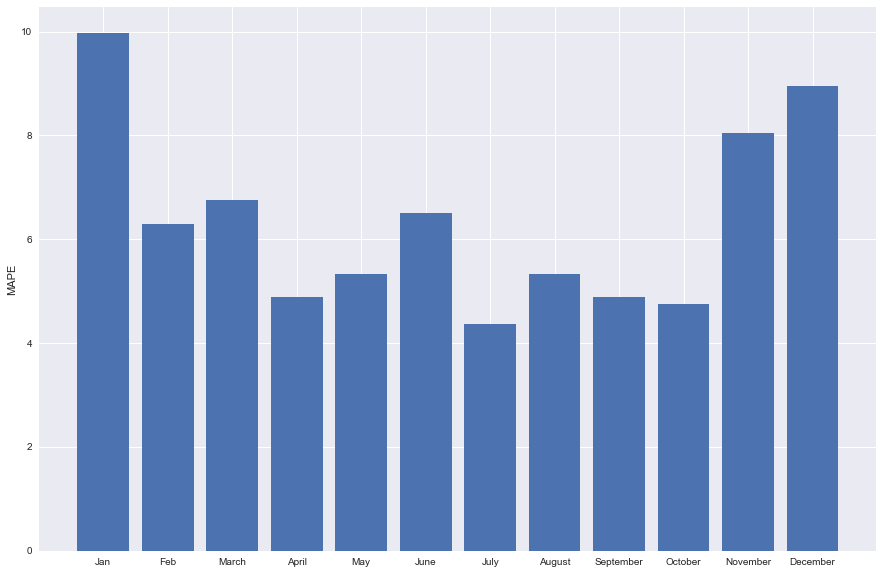

In [238]:
plt.bar(np.arange(12),arimax_2013_monthly_mape[0])
plt.xticks(np.arange(12), ('Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
                          'November', 'December'))
plt.ylabel('MAPE')
plt.show()

# Error Metrics, Comparisons and Plots

### MAPE

In [255]:
abcdef = pd.DataFrame({
    #'RF': temp_list_rf,
    'ARIMA': [0 for _ in range(12)] + arimax_2013_monthly_mape[0].values.tolist(),
    'RVM': temp_list2,
    'SVM': temp_list5,
    'MLP': temp_list4,
    'LASSO':temp_list6,
    'Proposed': temp_list,
    'RNN': temp_list7
})

In [256]:
abcdef_2013_only = pd.DataFrame({
    #'RF': temp_list_rf,
    'ARIMAX': arimax_2013_monthly_mape[0].values.tolist(),
    'RVM': temp_list2[12:],
    'SVM': temp_list5[12:],
    'MLP': temp_list4[12:],
    'LASSO':temp_list6[12:],
    'Proposed': temp_list[12:],
    'RNN': temp_list7[12:]
})

In [257]:
abcdef

,ARIMA,LASSO,MLP,Proposed,RNN,RVM,SVM
0,0.000000,5.999663,5.296013,4.293640,4.194868,5.146797,4.415831
1,0.000000,6.817706,5.771206,4.635081,4.825143,5.638769,6.394089
2,0.000000,8.704904,7.417770,6.461850,6.561684,6.824447,6.833338
3,0.000000,8.143816,7.152235,6.448600,6.333235,6.602746,6.908075
4,0.000000,7.489871,5.994762,5.331235,5.261935,5.496310,9.314504
5,0.000000,8.836651,7.764033,6.614011,7.331477,7.187632,8.980727
6,0.000000,6.114598,5.373918,4.859546,5.047404,4.699002,5.311429
7,0.000000,6.963185,6.126203,5.564193,5.805884,5.711608,5.936762
8,0.000000,6.313160,4.652980,4.009886,4.319574,4.721738,5.256295
9,0.000000,6.313121,5.572847,4.747925,4.525988,4.955445,5.836658


In [258]:
abcdef_2013_only

,ARIMAX,LASSO,MLP,Proposed,RNN,RVM,SVM
0,9.969808,10.440876,11.727758,8.742404,12.920145,9.739492,12.715823
1,6.293628,6.255314,6.482423,6.195045,6.836427,6.483449,6.891957
2,6.754909,6.776978,6.674825,6.199170,6.364293,6.514130,6.351289
3,4.895676,5.085315,4.797242,4.771335,4.865065,4.935240,5.056501
4,5.327291,5.582826,5.143525,4.831750,5.063597,5.053970,4.762039
5,6.500599,7.540050,6.433204,5.467501,6.060673,6.141388,6.460481
6,4.362385,4.796784,4.404079,3.884709,4.333432,4.590138,4.558843
7,5.328049,5.664158,5.265022,4.468019,4.800670,5.074092,5.211454
8,4.890992,5.958346,4.696651,4.406819,4.515378,4.586326,4.977578
9,4.745521,5.128649,4.499890,4.229183,4.450837,4.712096,4.681424


ARIMAX      6.338827
LASSO       6.748519
MLP         6.612828
Proposed    5.692307
RNN         6.495436
RVM         6.201827
SVM         6.556081
dtype: float64


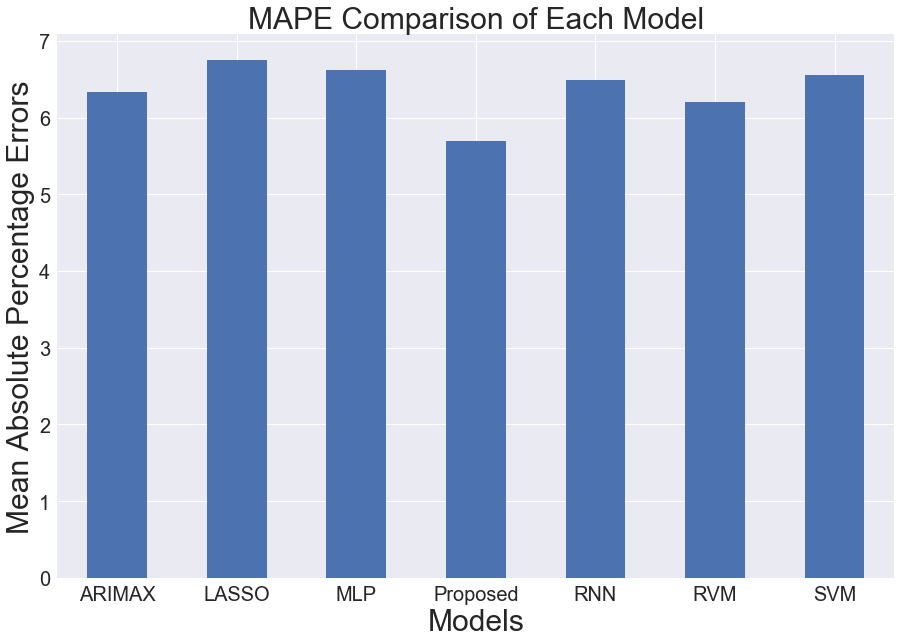

In [259]:
print(abcdef_2013_only.mean())
my_plt = abcdef_2013_only.mean().plot(kind='bar')
plt.xlabel("Models", {'fontsize':30})
plt.ylabel("Mean Absolute Percentage Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("MAPE Comparison of Each Model", {'fontsize':30})
plt.savefig("plot_mean_mape.jpg", format='jpg', bbox_inches='tight', dpi=600)

      ARIMAX      LASSO        MLP  Proposed        RNN       RVM        SVM
0   9.969808  10.440876  11.727758  8.742404  12.920145  9.739492  12.715823
5   6.500599   7.540050   6.433204  5.467501   6.060673  6.141388   6.460481
7   5.328049   5.664158   5.265022  4.468019   4.800670  5.074092   5.211454
10  8.045916   8.397260   9.851417  7.143993   8.278047  8.016772   8.217293


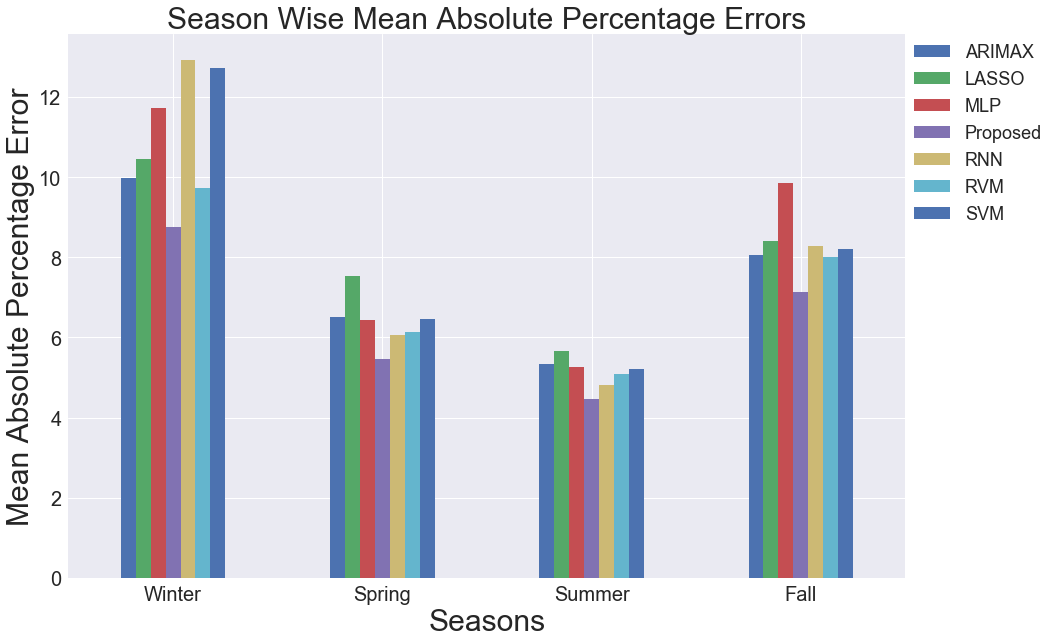

In [271]:
print(abcdef_2013_only.iloc[[0,5,7,10]])
abc = abcdef_2013_only.iloc[[0,5,7,10]].plot(kind='bar')
plt.xlabel("Seasons", {'fontsize':30})
plt.ylabel("Mean Absolute Percentage Error",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
abc.set_xticklabels(['Winter','Spring','Summer','Fall'])
plt.title("Season Wise Mean Absolute Percentage Errors", {'fontsize':30})
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1, fontsize=18)
plt.show()
plt.savefig("plot_season_mape.jpg", orientation='landscape', format='jpg', bbox_inches='tight', dpi=600)

### MAE

In [272]:
mae_df_final = pd.DataFrame({
    #'RF': mae_list_rf,
    'RVM': mae_list2,
    'SVM': mae_list5,
    'MLP': mae_list4,
    'LASSO':mae_list6,
    'Proposed': mae_list,
    'RNN': mae_list7
})

In [273]:
mae_df_final_2013_only = pd.DataFrame({
    'ARIMAX': arimax_2013_monthly_mae[0].values.tolist(),
    'RVM': mae_list2[12:],
    'SVM': mae_list5[12:],
    'MLP': mae_list4[12:],
    'LASSO':mae_list6[12:],
    'Proposed': mae_list[12:],
    'RNN': mae_list7[12:]
})

In [494]:
mae_df_final

,LASSO,MLP,Proposed,RNN,RVM,SVM
0,1.928790,1.713856,1.400695,1.371559,1.671706,1.450894
1,1.868700,1.623363,1.335507,1.386392,1.587707,1.740916
2,2.054348,1.821649,1.602286,1.641386,1.717845,1.681624
3,2.063548,1.838624,1.667209,1.650847,1.739431,1.756581
4,2.036412,1.678178,1.528887,1.505584,1.585304,2.438550
5,3.287186,2.926190,2.519390,2.797102,2.762545,3.126631
6,2.298874,2.142025,1.927296,2.058458,1.882547,2.060610
7,2.272507,2.067954,1.875556,1.970241,1.930458,1.935339
8,1.787056,1.349944,1.177387,1.267470,1.371946,1.475905
9,2.000423,1.643293,1.492254,1.451281,1.603209,1.830556


In [336]:
mae_df_final_2013_only

,ARIMAX,LASSO,MLP,Proposed,RNN,RVM,SVM
0,11.761123,13.019127,13.809827,10.728546,17.379462,12.035236,16.647548
1,2.671699,2.689854,2.813227,2.572834,2.895382,2.720499,2.828502
2,3.289514,3.302140,3.291703,3.065506,3.122784,3.201588,3.162130
3,2.213394,2.265089,2.194980,2.149191,2.196872,2.230086,2.246444
4,2.247896,2.312852,2.233241,2.096965,2.193056,2.210372,2.028651
5,2.972234,3.294428,3.003026,2.565811,2.883731,2.814752,2.905527
6,1.606889,1.735859,1.629134,1.441131,1.637998,1.691005,1.653690
7,2.029359,2.107978,1.973628,1.731520,1.859466,1.930593,1.926878
8,1.450875,1.730612,1.401966,1.315166,1.341318,1.379715,1.457651
9,1.727924,1.843958,1.641987,1.544013,1.619326,1.715587,1.697667


LASSO       3.246411
MLP         3.167030
Proposed    2.695330
RNN         3.200620
RVM         2.924210
SVM         3.195393
dtype: float64

ARIMAX      3.676095
LASSO       3.900880
MLP         3.940588
Proposed    3.304661
RNN         4.195035
RVM         3.607849
SVM         4.000002
dtype: float64


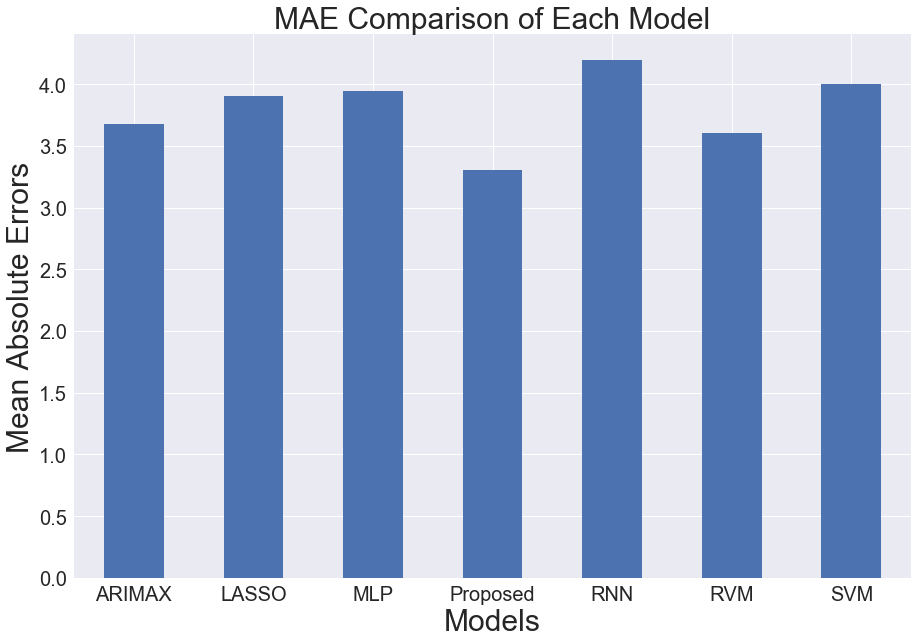

In [283]:
print(mae_df_final.mean(), end='\n\n')
print(mae_df_final_2013_only.mean())
my_plt = mae_df_final_2013_only.mean().plot(kind='bar')
plt.xlabel("Models", {'fontsize':30})
plt.ylabel("Mean Absolute Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("MAE Comparison of Each Model", {'fontsize':30})
plt.show()
#plt.savefig("plot_mean_mae.jpg")

### RMSE

In [287]:
rmse_df_final = pd.DataFrame({
    #'RF': rmse_list_rf,
    'RVM': rmse_list2,
    'SVM': rmse_list5,
    'MLP': rmse_list4,
    'LASSO':rmse_list6,
    'Proposed': rmse_list,
    'RNN': rmse_list7
})

In [293]:
rmse_df_final_2013_only = pd.DataFrame({
    #'RF': rmse_list_rf,
    'ARIMAX': arimax_2013_monthly_rmse[0].values.tolist(),
    'RVM': rmse_list2[12:],
    'SVM': rmse_list5[12:],
    'MLP': rmse_list4[12:],
    'LASSO':rmse_list6[12:],
    'Proposed': rmse_list[12:],
    'RNN': rmse_list7[12:]
})

LASSO       4.470762
MLP         4.399179
Proposed    3.782905
RNN         4.456137
RVM         4.056572
SVM         4.429235
dtype: float64

ARIMAX      5.181237
LASSO       5.360267
MLP         5.437219
Proposed    4.616649
RNN         5.768364
RVM         4.974598
SVM         5.588318
dtype: float64


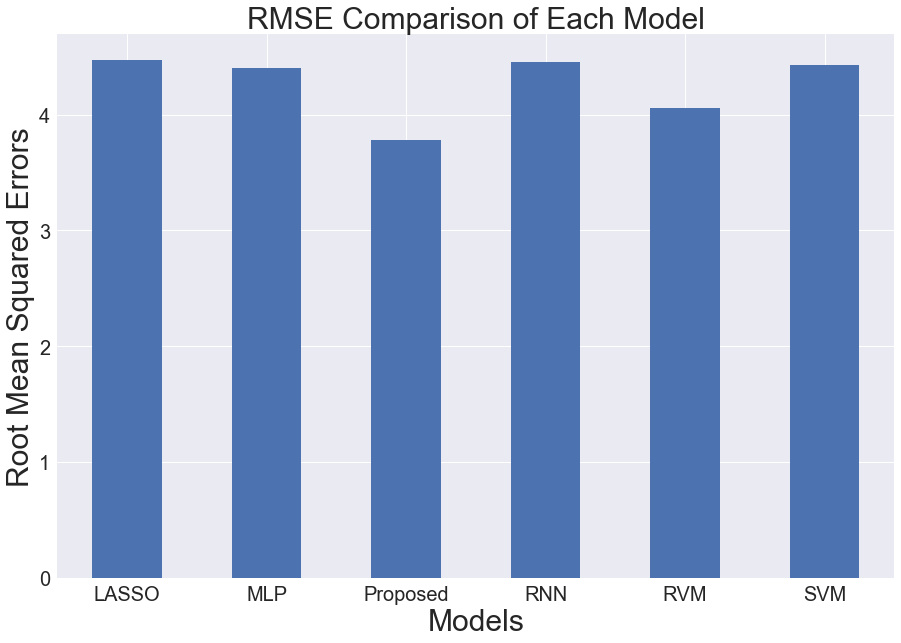

In [294]:
print(rmse_df_final.mean(), end='\n\n')
print(rmse_df_final_2013_only.mean())
my_plt = rmse_df_final.mean().plot(kind='bar')
plt.xlabel("Models", {'fontsize':30})
plt.ylabel("Root Mean Squared Errors",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("RMSE Comparison of Each Model", {'fontsize':30})
plt.savefig("plot_mean_rmse.jpg")

# Trend Plots

In [609]:
test_for_final_comparisons = test.copy()

In [610]:
test_for_final_comparisons['Proposed'] = stacked_preds_price
test_for_final_comparisons['RVM'] = rvm_pol_preds_price
test_for_final_comparisons['SVM'] = svm_rbf_preds_price
test_for_final_comparisons['XGB'] = xgb_reg_preds_price
test_for_final_comparisons['LASSO'] = lasso_preds_price
test_for_final_comparisons['RNN'] = rnn_preds_price
test_for_final_comparisons['MLP'] = mlp_reg_preds_price
test_for_final_comparisons['RF'] = rf_preds_price

In [611]:
test_for_final_comparisons['YEAR'] = test_for_final_comparisons['Date'].apply(lambda x: x.year)
test_for_final_comparisons['MONTH'] = test_for_final_comparisons['Date'].apply(lambda x: x.month)
test_for_final_comparisons['WEEK'] = test_for_final_comparisons['Date'].apply(lambda x: x.week)

In [612]:
test_for_final_comparisons_2013_only = test_for_final_comparisons[test_for_final_comparisons['YEAR'] == 2013]

In [613]:
test_for_final_comparisons_2013_only['ARIMAX'] = arimax_for_comparison['Predicted_Values'].values.tolist()

In [615]:
test_for_final_comparisons_2013_only.head()

,Date,Hour,DA_DEMD_actual_value,DA_LMP_actual_value,DA_EC,DA_CC,DA_MLC,DryBulb_actual_value,DewPnt_actual_value,Day,...,SVM,XGB,LASSO,RNN,MLP,RF,YEAR,MONTH,WEEK,ARIMAX
2136,2013-01-24,1.0,13325.0,194.44,193.16,0.0,1.28,4.0,-11.0,5.0,...,179.956234,188.842896,198.584316,206.720123,182.213064,198.669935,2013,1,4,190.338251
2137,2013-01-24,2.0,13181.0,183.04,181.78,0.0,1.26,3.0,-11.0,5.0,...,176.768853,192.366943,187.244192,204.978729,183.755946,195.016336,2013,1,4,177.875534
2138,2013-01-24,3.0,13073.0,166.02,164.94,0.0,1.08,3.0,-11.0,5.0,...,174.873380,182.168808,175.647323,190.492447,183.518784,186.822828,2013,1,4,167.252244
2139,2013-01-24,4.0,13062.0,165.15,164.05,0.0,1.10,3.0,-11.0,5.0,...,189.782804,194.192993,178.470740,194.623718,199.645169,195.587865,2013,1,4,170.583737
2140,2013-01-24,5.0,13172.0,174.64,173.32,0.0,1.32,1.0,-10.0,5.0,...,210.429306,215.409042,200.134663,214.244278,210.197125,235.123212,2013,1,4,193.854045


### Plot Predicted Vs. Actual

### Single Day

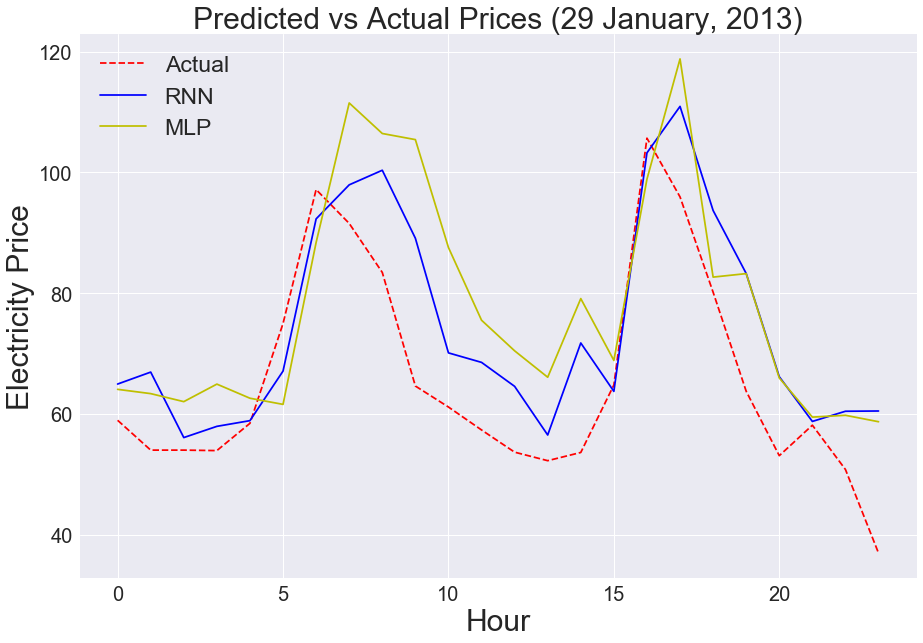

In [628]:
#import matplotlib.pyplot as plt
start = 0+24+24+24+24+24
end = start + 24

temp = pd.DataFrame({
    'Actual':test_for_final_comparisons_2013_only['TARGET_DA_LMP'][start:end],
    'RNN':test_for_final_comparisons_2013_only['RNN'][start:end],
    'MLP':test_for_final_comparisons_2013_only['MLP'][start:end],
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Actual'], 'r--', label="Actual")
plt.plot(temp['RNN'], 'b-', label="RNN")
plt.plot(temp['MLP'], 'y-', label="MLP")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (29 January, 2013)", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
plt.gcf()
plt.savefig("NEWPLOTS_Feb19/plot_single_day1.jpg", format='jpg', bbox_inches='tight', dpi=600)

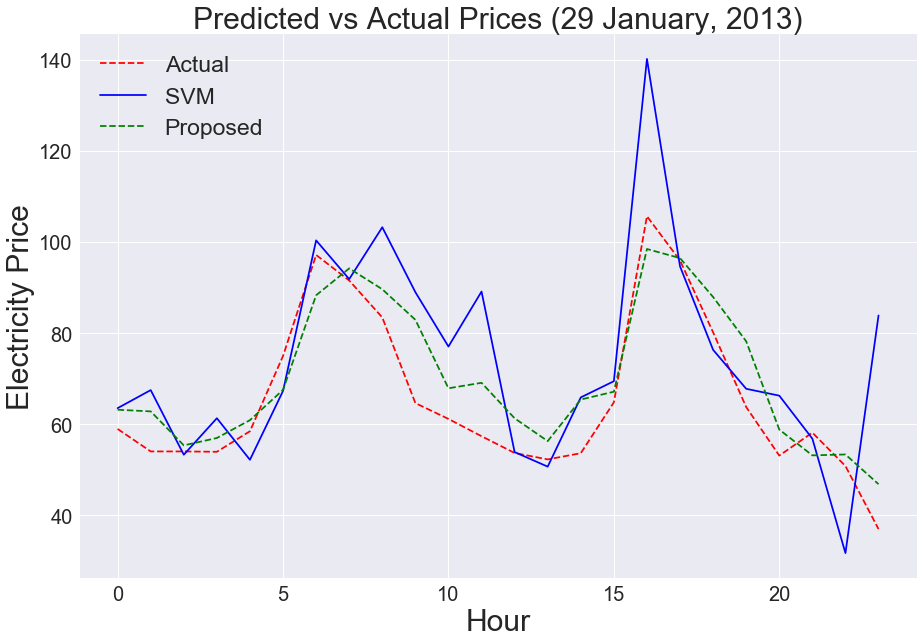

In [629]:
start = 0+24+24+24+24+24
end = start + 24

temp = pd.DataFrame({
    'Actual':test_for_final_comparisons_2013_only['TARGET_DA_LMP'][start:end],
    'SVM':test_for_final_comparisons_2013_only['SVM'][start:end],
    'Proposed':test_for_final_comparisons_2013_only['Proposed'][start:end],
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Actual'], 'r--', label="Actual")
plt.plot(temp['SVM'], 'b-', label="SVM")
plt.plot(temp['Proposed'], 'g--', label="Proposed")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (29 January, 2013)", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
plt.gcf()
plt.savefig("NEWPLOTS_Feb19/plot_single_day2.jpg", format='jpg', bbox_inches='tight', dpi=600)

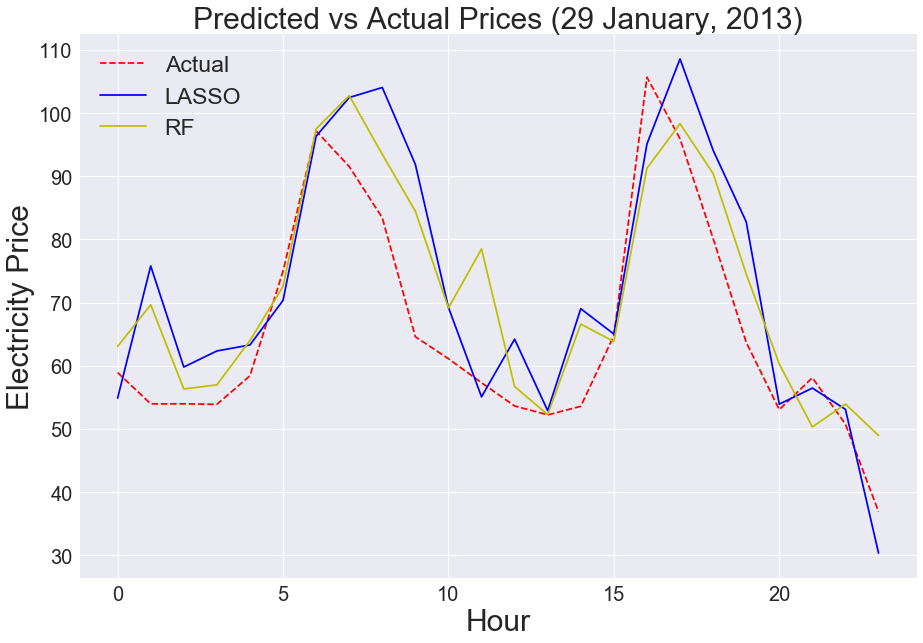

In [631]:
#import matplotlib.pyplot as plt
start = 0+24+24+24+24+24
end = start + 24

temp = pd.DataFrame({
    'Actual':test_for_final_comparisons_2013_only['TARGET_DA_LMP'][start:end],
    'LASSO':test_for_final_comparisons_2013_only['LASSO'][start:end],
    'RF':test_for_final_comparisons_2013_only['RF'][start:end],
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Actual'], 'r--', label="Actual")
plt.plot(temp['LASSO'], 'b-', label="LASSO")
plt.plot(temp['RF'], 'y-', label="RF")
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (29 January, 2013)", {'fontsize':30})
plt.legend(loc=2, fontsize=23)
plt.gcf()
plt.savefig("NEWPLOTS_Feb19/plot_single_day3.jpg", format='jpg', bbox_inches='tight', dpi=600)

### WEEK

In [632]:
week_trend_plots = test_for_final_comparisons_2013_only[test_for_final_comparisons_2013_only['MONTH'] == 1]

In [633]:
week_trend_plots.shape

(192, 38)

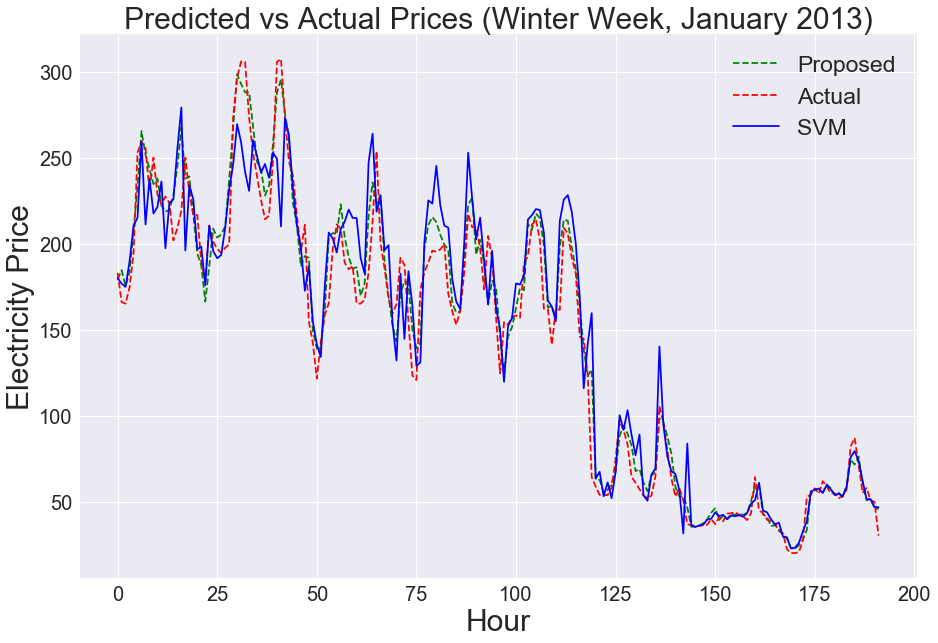

In [634]:
#import matplotlib.pyplot as plt

temp = pd.DataFrame({
    'Proposed':week_trend_plots['Proposed'], 
    'Actual':week_trend_plots['TARGET_DA_LMP'],
    'SVM':week_trend_plots['SVM'],
})
temp = temp.reset_index(drop=True)
plt.plot(temp['Proposed'], 'g--', label="Proposed")
plt.plot(temp['Actual'], 'r--', label="Actual")
plt.plot(temp['SVM'], 'b-', label="SVM")
#temp.plot(kind='line')
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (Winter Week, January 2013)", {'fontsize':30})
plt.legend(loc=1, fontsize=23)
plt.gcf()
plt.savefig("NEWPLOTS_Feb19/plot_winter_week1.jpg", format='jpg', bbox_inches='tight', dpi=600)

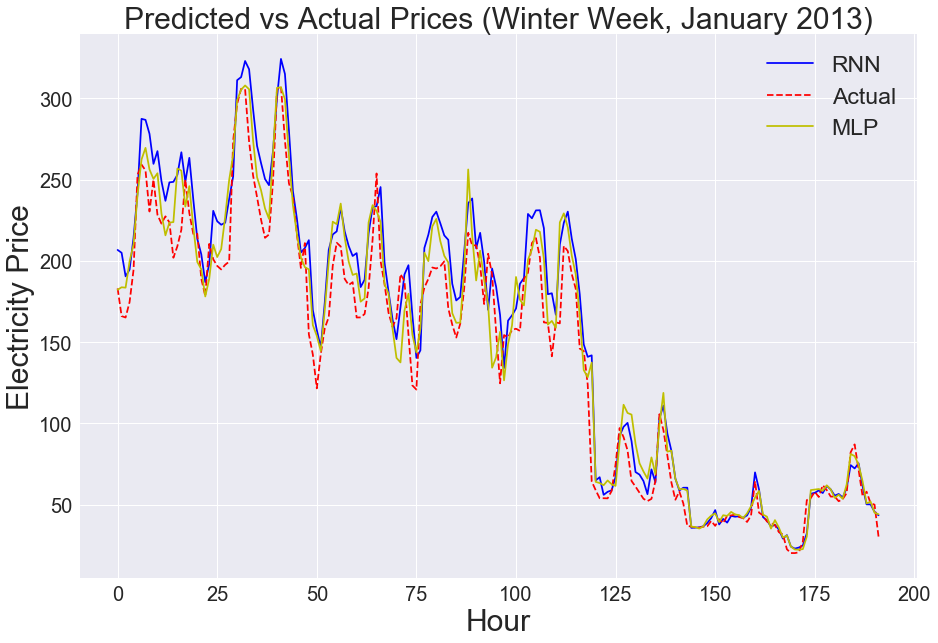

In [635]:
#import matplotlib.pyplot as plt
temp = pd.DataFrame({
    'RNN':week_trend_plots['RNN'], 
    'Actual':week_trend_plots['TARGET_DA_LMP'],
    'MLP':week_trend_plots['MLP'],
})
temp = temp.reset_index(drop=True)
plt.plot(temp['RNN'], 'b-', label="RNN")
plt.plot(temp['Actual'], 'r--', label="Actual")
plt.plot(temp['MLP'], 'y-', label="MLP")
#temp.plot(kind='line')
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (Winter Week, January 2013)", {'fontsize':30})
plt.legend(loc=1, fontsize=23)
plt.gcf()
plt.savefig("NEWPLOTS_Feb19/plot_winter_week2.jpg", format='jpg', bbox_inches='tight', dpi=600)

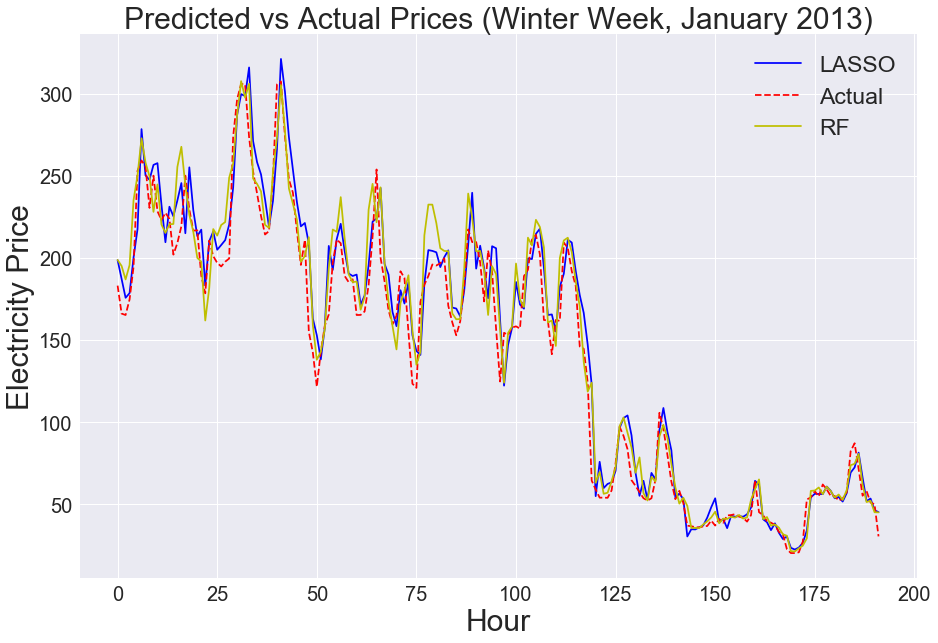

In [636]:
temp = pd.DataFrame({
    'LASSO':week_trend_plots['LASSO'], 
    'Actual':week_trend_plots['TARGET_DA_LMP'],
    'RF':week_trend_plots['RF']
})
temp = temp.reset_index(drop=True)
plt.plot(temp['LASSO'], 'b-', label="LASSO")
plt.plot(temp['Actual'], 'r--', label="Actual")
plt.plot(temp['RF'], 'y-', label="RF")
#temp.plot(kind='line')
plt.xlabel("Hour", {'fontsize':30})
plt.ylabel("Electricity Price",{'fontsize':30})
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.title("Predicted vs Actual Prices (Winter Week, January 2013)", {'fontsize':30})
plt.legend(loc=1, fontsize=23)
plt.gcf()
plt.savefig("NEWPLOTS_Feb19/plot_winter_week3.jpg", format='jpg', bbox_inches='tight', dpi=600)